In [1]:
import h5py
import numpy as np
import pandas as pd
from scipy.interpolate import RegularGridInterpolator
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator, interp1d

In [2]:
# Данные для 3TC и AZT (NRTI)
IC50_3TC = 0.0558 * 651 / 1000  # µM
IC50_AZT = 1.7594 * 267 / 1000  # µM
# Данные для DRV (PI)
IC50_DRV = 0.0264 * 547.66 / 1000 / 7 # µM

# inhibitors
inhibitors = pd.DataFrame({
    "tag" : ["DRV", "3TC", "AZT"],
    "IC50" : [IC50_DRV, IC50_3TC, IC50_AZT],
    "m" : [2.14, 0.97, 0.62],
    "target" : ["k_mat", "k_RT", "k_RT"] 
})

### __calc u1__

In [3]:
with h5py.File('data/matrix_u1.h5', 'r') as f:
    data = f['matrix'][:] 
data = 1-data

In [4]:
n_NRTI1_values = np.linspace(0, 1, 11)  
n_NRTI2_values = np.linspace(0, 1, 11)

In [5]:
interpolator = RegularGridInterpolator(
    (n_NRTI2_values, n_NRTI1_values),  
    data,                             
    method='linear',                             
    bounds_error=False,                          
    fill_value=np.nan                         
)

In [6]:
n_NRTI1_values = np.linspace(0, 1, 30)  
n_NRTI2_values = np.linspace(0, 1, 30)

In [7]:
c3_fixed = 0.0
points_c2 = np.column_stack([
    np.full_like(n_NRTI1_values, c3_fixed),  # C3 = 0 для всех точек
    n_NRTI1_values,                          # C2 меняется
])
u1_c2 = interpolator(points_c2)

# Зависимость u1 от C3 (при C2=0, C1=0.5)
c2_fixed = 0.0
points_c3 = np.column_stack([
    n_NRTI2_values,                          # C3 меняется
    np.full_like(n_NRTI2_values, c2_fixed),  # C2 = 0 для всех точек
])
u1_c3 = interpolator(points_c3)

In [8]:
drugs = {
    "RDV": {
        "D": 600,       # мг
        "k_a": 2.4,     # д^-1
        "Cl": 1.48e4,   # л/день
        "V_c": 28.7,    # л
        "F": 1.0,       # безразмерный
        "tau": 1/2,     # день (интервал дозирования)
        "IC50": 0.11    # мг/л
    },
    "3TC": {
        "D": 150,
        "k_a": 12,
        "Cl": 5.6e2,
        "V_c": 91,
        "F": 0.86,
        "tau": 1/2,
        "IC50": 0.34
    },
    "ZDV": {
        "D": 300,
        "k_a": 12,
        "Cl": 2.69e3,
        "V_c": 112,
        "F": 0.64,
        "tau": 1/2,
        "IC50": 0.13
    }
}


IC50_2 = drugs["3TC"]["IC50"]  
IC50_3 = drugs["ZDV"]["IC50"]

# График u1(C2) при C3 = 0
C2_values = np.linspace(0.001, 1, 100)
u1_values = (C2_values / IC50_2) / (1 + C2_values / IC50_2)

# График u1(C3) при C2 = 0
C3_values = np.linspace(0.00001, 1, 100)
u1_values = (C3_values / IC50_3) / (1 + C3_values / IC50_3)

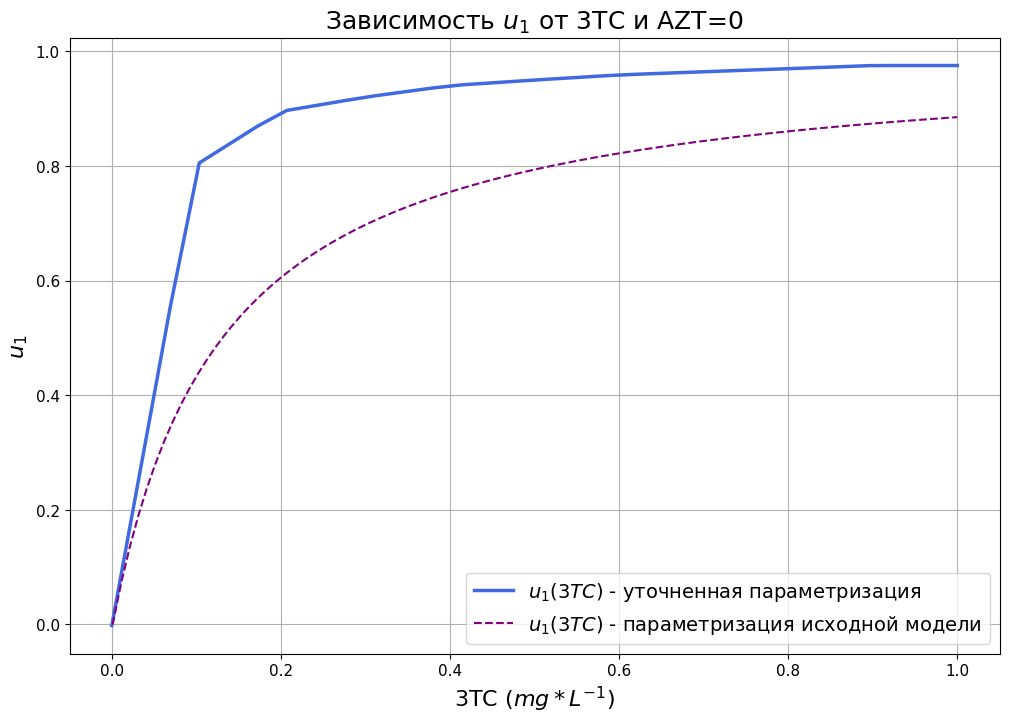

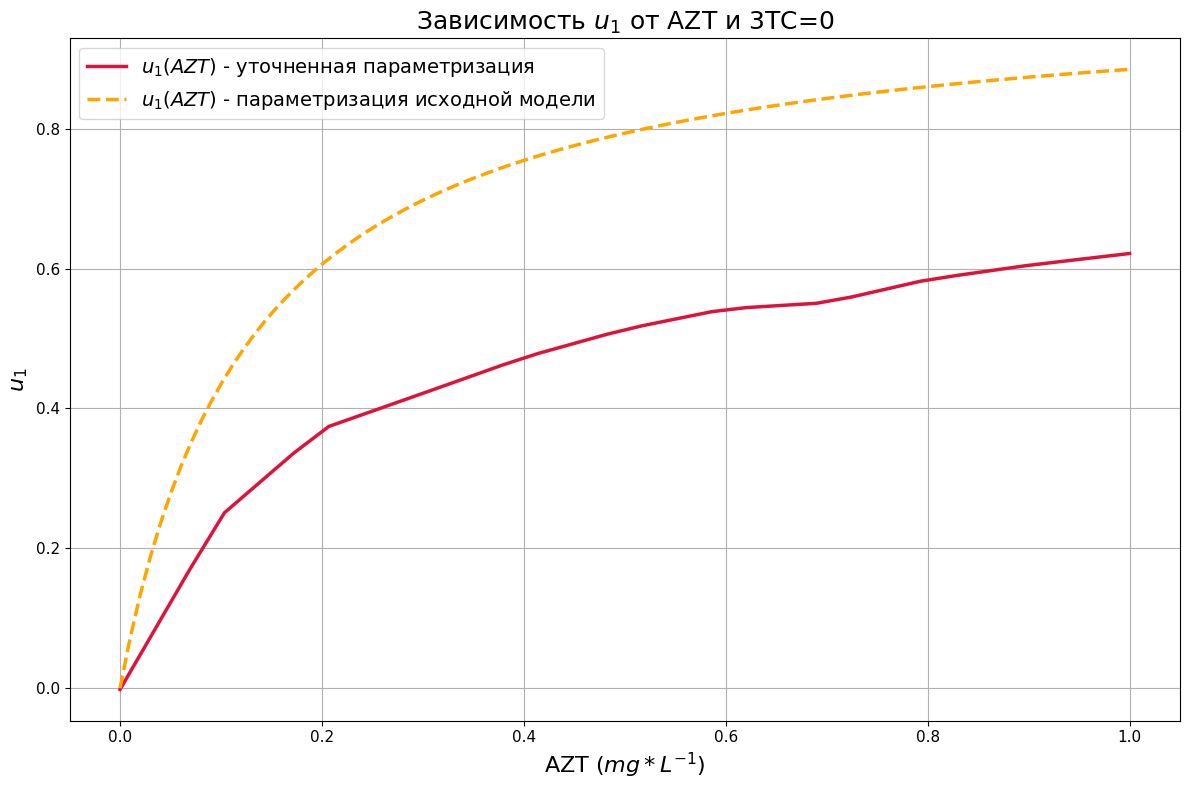

In [11]:
plt.figure(figsize=(12, 8))
plt.plot(n_NRTI1_values, u1_c2, label='$u_1(3TC)$ - уточненная параметризация', color='royalblue', linewidth=2.5)
plt.plot(C2_values, u1_values, label='$u_1(3TC)$ - параметризация исходной модели', linestyle="--", color='purple')
plt.xlabel(r"3TC $(mg*L^{-1})$", fontsize=16)
plt.ylabel("$u_1$", fontsize=16)
plt.title("Зависимость $u_1$ от 3TC и AZT=0", fontsize=18)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.legend(fontsize=14)
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 8))
plt.plot(n_NRTI2_values, u1_c3, label='$u_1(AZT)$ - уточненная параметризация', color='crimson', linewidth=2.5)
plt.plot(C3_values, u1_values, label='$u_1(AZT)$ - параметризация исходной модели', color='orange', linestyle="--", linewidth=2.5)
plt.xlabel(r"AZT $(mg*L^{-1})$", fontsize=16)
plt.ylabel("$u_1$", fontsize=16)
plt.title("Зависимость $u_1$ от AZT и 3TC=0", fontsize=18)
plt.legend(fontsize=14)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.grid(True)

plt.tight_layout()
plt.show()

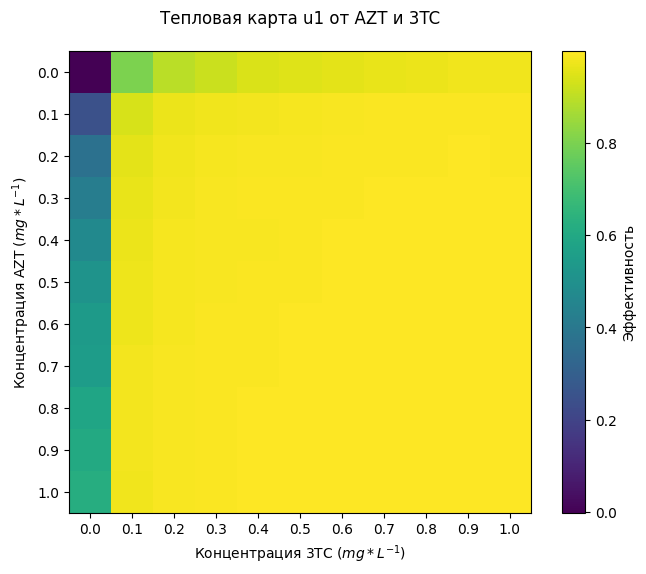

In [12]:
plt.figure(figsize=(8, 6))

plt.imshow(data, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Эффективность')  

plt.title('Тепловая карта u1 от AZT и 3TC', pad=20)
plt.xlabel(r'Концентрация 3TC $(mg*L^{-1})$')
plt.ylabel(r'Концентрация AZT $(mg*L^{-1})$')

n_ticks = data.shape[0] 
x_ticks = np.linspace(0, 1, n_ticks)
y_ticks = np.linspace(0, 1, n_ticks)

# Подписи для осей X и Y
plt.xticks(np.linspace(0, data.shape[1] - 1, n_ticks), 
           labels=[f"{x:.1f}" for x in x_ticks])
plt.yticks(np.linspace(0, data.shape[0] - 1, n_ticks), 
           labels=[f"{y:.1f}" for y in y_ticks])

plt.show()

### __calc ε__

In [13]:
V_mat_pi=[1.0, 0.9398690698810498, 0.7798093155659221, 0.597535733024898, 0.44473999535596426, 
          0.3316620781969938, 0.25128974531649045, 0.19430300382924123, 0.15335410148577966, 
          0.1233641228744624, 0.10095143885074094, 0.083871371473707, 0.0706175355047732, 
          0.06016213646116872, 0.05179090287531578, 0.04499818836739459, 0.03941961825394634, 
          0.03478819384187885, 0.030905203949255448, 0.027620617811439315, 0.024819646828684358]

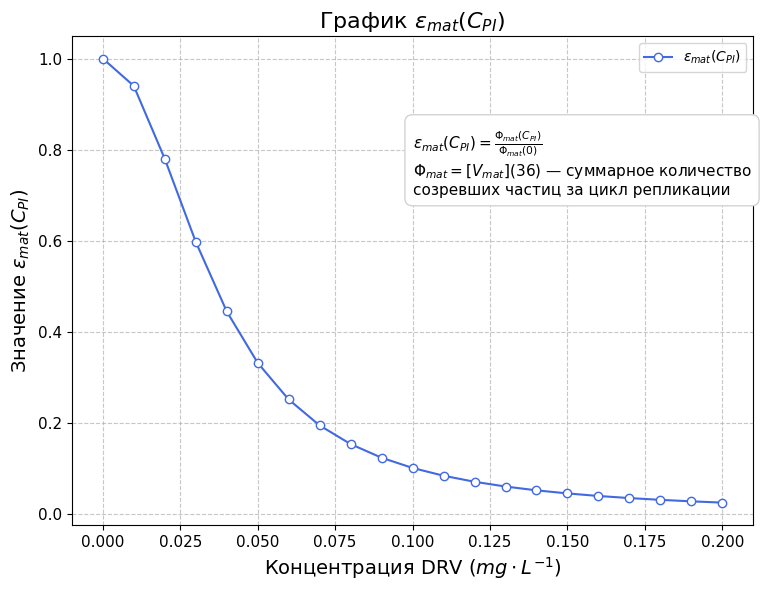

In [14]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8, 6))
plt.plot(np.linspace(0, 0.2, len(V_mat_pi)), V_mat_pi, 
         color="royalblue", marker="o", markersize=6, 
         markerfacecolor='white', label=r'$\varepsilon_{mat}(C_{PI})$')

plt.xlabel(r"Концентрация DRV $(mg \cdot L^{-1})$", fontsize=14)
plt.ylabel(r"Значение $\varepsilon_{mat}(C_{PI})$", fontsize=14)
plt.title(r"График $\varepsilon_{mat}(C_{PI})$", fontsize=16)


plt.text(0.1, 0.7,
         r"$\varepsilon_{mat}(C_{PI}) = \frac{\Phi_{mat}(C_{PI})}{\Phi_{mat}(0)}$" + "\n" +
         r"$\Phi_{mat}=[V_{mat}](36)$ — суммарное количество" + "\n" +
         r"созревших частиц за цикл репликации",
         fontsize=11, 
         bbox=dict(facecolor='white', edgecolor='lightgray', boxstyle='round,pad=0.5'))

plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout() 
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.show()

### __calc PI__

In [39]:
with h5py.File('data/matrix_PI.h5', 'r') as f:
    data_pi = f['matrix'][:] 
data_pi = 1-data_pi

In [40]:
n_PI_values = np.linspace(0, 0.07, data_pi.shape[0])  

In [41]:
interpolator_pi = interp1d(
    n_PI_values,  
    data_pi,                             
    kind='linear'                                                
)

In [42]:
n_PI_values = np.linspace(0, 0.07, 40)  
points_c1 = n_PI_values
f_u_pi = interpolator_pi(points_c1)

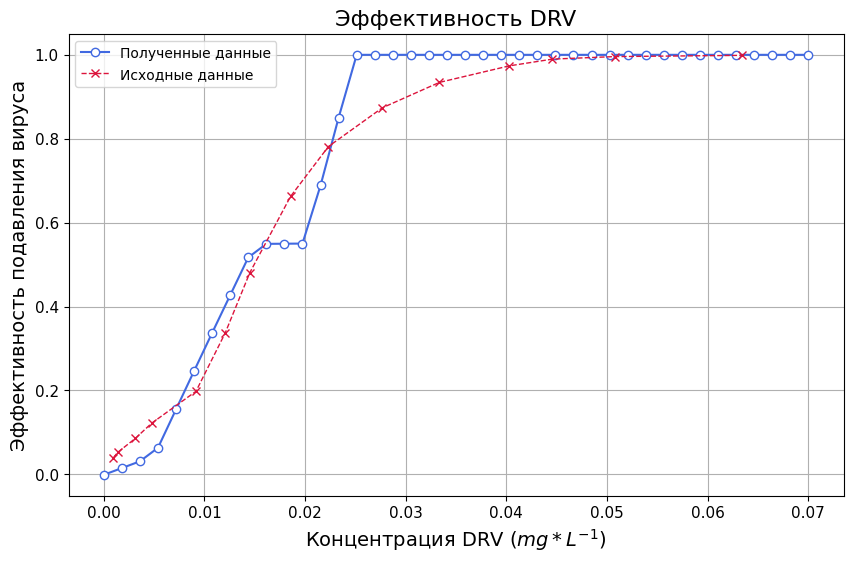

In [43]:
plt.figure(figsize=(10, 6))
plt.plot(n_PI_values, f_u_pi, color = "royalblue", marker = "o", markersize=6, markerfacecolor='white', label="Полученные данные")
plt.xlabel(r"Концентрация DRV $(mg*L^{-1})$", fontsize=14)
plt.ylabel(r"Эффективность подавления вируса", fontsize=14)
plt.grid(True)

drv_csv = pd.read_csv('data/DRV.csv', header=None)
drv_csv = 10 ** drv_csv
drv_csv[0] = drv_csv[0] * 548 / 1000
drv_csv[1] = 1 - (drv_csv[1] + 1) ** (-1)

plt.plot(drv_csv[0], drv_csv[1], '--', color='crimson', alpha=1., linewidth=1, marker='x', label="Исходные данные")
plt.title("Эффективность DRV", fontsize=16)
plt.legend()
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.show()

### __calc u2__

In [20]:
with h5py.File('data/matrix_u2.h5', 'r') as f:
    data_u2 = f['matrix'][:] 
data_u2 = 1-data_u2

In [21]:
data_u2.shape

(11, 11, 15)

In [22]:
n_PI_values = np.linspace(0, 0.07, data_u2.shape[-1])  
n_NRTI1_values = np.linspace(0, 1, data_u2.shape[1])  
n_NRTI2_values = np.linspace(0, 1, data_u2.shape[0])

In [23]:
interpolator_u2 = RegularGridInterpolator(
    (n_NRTI2_values, n_NRTI1_values, n_PI_values),  
    data_u2,                             
    method='linear',                             
    bounds_error=False,                          
    fill_value=np.nan                         
)

In [24]:
c2_fixed = 0.0
c3_fixed = 0.0
points_c3_1 = np.column_stack([
    np.full_like(n_PI_values, c3_fixed), 
    np.full_like(n_PI_values, c2_fixed),  
    n_PI_values # C1 = 0.5
])
u2_c1_1 = interpolator_u2(points_c3_1)


c2_fixed = 0.2
c3_fixed = 0.0
points_c3_2 = np.column_stack([
    np.full_like(n_PI_values, c3_fixed), 
    np.full_like(n_PI_values, c2_fixed),  
    n_PI_values # C1 = 0.5
])
u2_c1_2 = interpolator_u2(points_c3_2)

c2_fixed = 0.0
c3_fixed = 0.5
points_c3_3 = np.column_stack([
    np.full_like(n_PI_values, c3_fixed), 
    np.full_like(n_PI_values, c2_fixed),  
    n_PI_values # C1 = 0.5
])
u2_c1_3 = interpolator_u2(points_c3_3)

c2_fixed = 0.2
c3_fixed = 0.5
points_c3_4 = np.column_stack([
    np.full_like(n_PI_values, c3_fixed), 
    np.full_like(n_PI_values, c2_fixed),  
    n_PI_values # C1 = 0.5
])
u2_c1_4 = interpolator_u2(points_c3_4)

In [25]:
drugs = {
    "RDV": {
        "D": 600,       # мг
        "k_a": 2.4,     # д^-1
        "Cl": 1.48e4,   # л/день
        "V_c": 28.7,    # л
        "F": 1.0,       # безразмерный
        "tau": 1/2,     # день (интервал дозирования)
        "IC50": 0.11    # мг/л
    },
    "3TC": {
        "D": 150,
        "k_a": 12,
        "Cl": 5.6e2,
        "V_c": 91,
        "F": 0.86,
        "tau": 1/2,
        "IC50": 0.34
    },
    "ZDV": {
        "D": 300,
        "k_a": 12,
        "Cl": 2.69e3,
        "V_c": 112,
        "F": 0.64,
        "tau": 1/2,
        "IC50": 0.13
    }
}

IC50_1 = drugs["RDV"]["IC50"] 

omega = 1
C1_values = np.linspace(0.001, 1, 100)
u2_values = C1_values / (C1_values + omega * IC50_1)

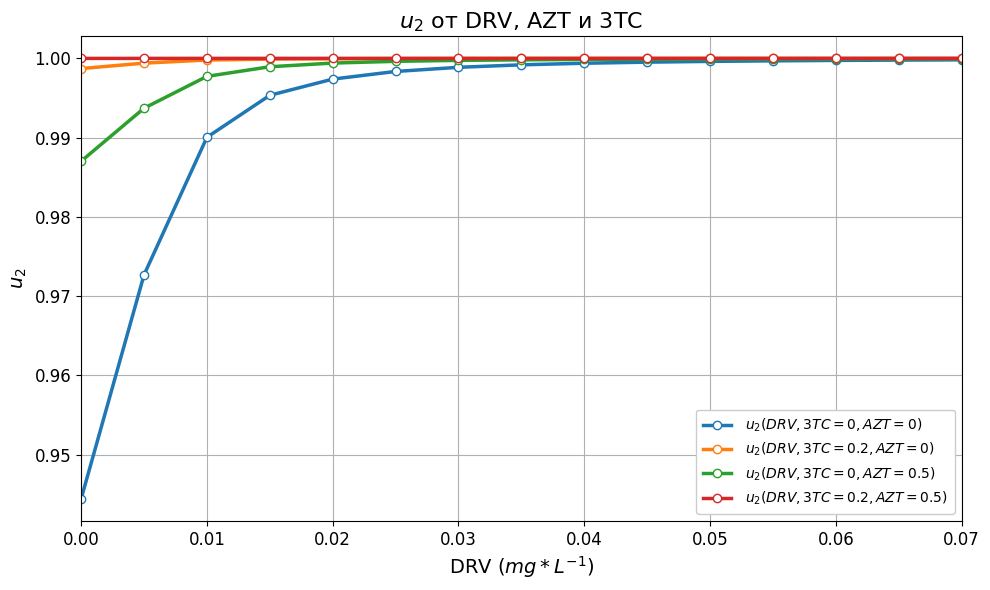

In [26]:
plt.figure(figsize=(10, 6))

plt.plot(n_PI_values, u2_c1_1, label='$u_2(DRV, 3TC=0, AZT=0)$', linewidth=2.5, marker='o', markersize=6, markerfacecolor='white' )
plt.plot(n_PI_values, u2_c1_2, label='$u_2(DRV, 3TC=0.2, AZT=0)$', linewidth=2.5, marker='o', markersize=6, markerfacecolor='white' )
plt.plot(n_PI_values, u2_c1_3, label='$u_2(DRV, 3TC=0, AZT=0.5)$', linewidth=2.5, marker='o', markersize=6, markerfacecolor='white' )
plt.plot(n_PI_values, u2_c1_4, label='$u_2(DRV, 3TC=0.2, AZT=0.5)$', linewidth=2.5, marker='o', markersize=6, markerfacecolor='white' )

plt.xlabel(r"DRV ($mg*L^{-1}$)", fontsize=14)
plt.ylabel("$u_2$", fontsize=14)

plt.title("$u_2$ от DRV, AZT и 3TC", fontsize=16)
plt.xlim(0, 0.07)
plt.legend(
    handletextpad=1.0,  # сдвигаем текст дальше от линии
    labelspacing=0.5,   # расстояние между строками
    borderpad=0.5,      # отступ текста от края легенды
    framealpha=1        # прозрачность фона (1 = непрозрачный)
)
plt.grid(True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


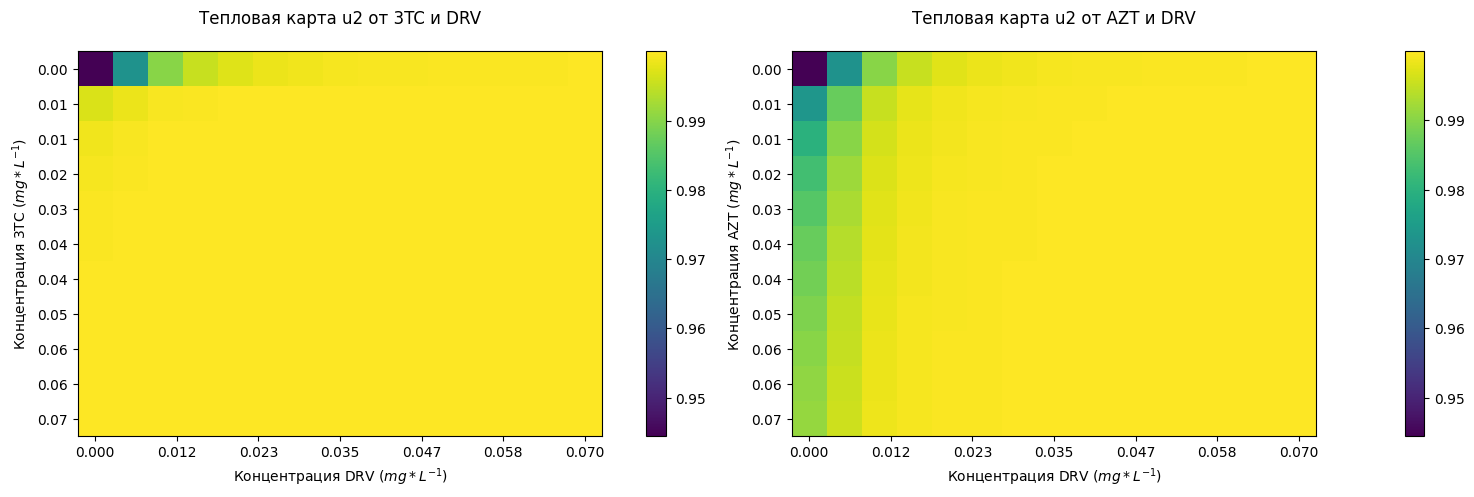

In [27]:
plt.figure(figsize=(18, 10))

plt.subplot(2, 1, 1)
im1 = plt.imshow(data_u2[:, 0, :], cmap='viridis', interpolation='nearest')
cbar1 = plt.colorbar(im1)

plt.title('Тепловая карта u2 от AZT и DRV', pad=20)
plt.xlabel(r'Концентрация DRV ($mg*L^{-1}$)')
plt.ylabel(r'Концентрация AZT ($mg*L^{-1}$)')

n_ticks = data_u2.shape[0] 
m_ticks = data_u2.shape[-1] // 2
x_ticks = np.linspace(0, 0.07, m_ticks)
y_ticks = np.linspace(0, 0.07, n_ticks)

plt.xticks(np.linspace(0, data_u2.shape[-1] - 1, m_ticks), 
           labels=[f"{x:.3f}" for x in x_ticks])
plt.yticks(np.linspace(0, data_u2.shape[0] - 1, n_ticks), 
           labels=[f"{y:.2f}" for y in y_ticks])

plt.subplot(2, 2, 1)
im2 = plt.imshow(data_u2[0, :, :], cmap='viridis', interpolation='nearest')
cbar2 = plt.colorbar(im2)

plt.title('Тепловая карта u2 от 3TC и DRV', pad=20)
plt.xlabel(r'Концентрация DRV ($mg*L^{-1}$)')
plt.ylabel(r'Концентрация 3TC ($mg*L^{-1}$)')

plt.xticks(np.linspace(0, data_u2.shape[-1] - 1, m_ticks), 
           labels=[f"{x:.3f}" for x in x_ticks])
plt.yticks(np.linspace(0, data_u2.shape[0] - 1, n_ticks), 
           labels=[f"{y:.2f}" for y in y_ticks])

plt.tight_layout()
plt.show()

### __calc stachostic (in developing)__ 

In [28]:
with h5py.File('data/matrix3d_100.h5', 'r') as f:
    data_3d = f['matrix'][:] 
data_3d.shape

(11, 11, 11, 100)

In [29]:
averaged_matrix = 1- np.mean(data_3d, axis=-1)
averaged_matrix.shape

(11, 11, 11)

In [30]:
n_PI_values = np.linspace(0, 0.2, averaged_matrix.shape[-1])  
n_NRTI1_values = np.linspace(0, 1, averaged_matrix.shape[1])  
n_NRTI2_values = np.linspace(0, 1, averaged_matrix.shape[0])

In [31]:
interpolator_3d = RegularGridInterpolator(
    (n_NRTI2_values, n_NRTI1_values, n_PI_values),  
    averaged_matrix,                             
    method='linear',                             
    bounds_error=False,                          
    fill_value=np.nan                         
)

In [32]:
n_PI_values = [0.0, 0.003, 0.005, 0.007, 0.01, 0.012, 0.015, 0.017, 0.02, 0.025, 0.04, 0.08, 0.10, 0.12, 0.14, 0.16, 0.18, 0.20]

c2_fixed = 0.2
c3_fixed = 0.2
points_c3 = np.column_stack([
    np.full_like(n_PI_values, c3_fixed), 
    np.full_like(n_PI_values, c2_fixed),  
    n_PI_values # C1 = 0.5
])
u2_c1_3d = interpolator_3d(points_c3)

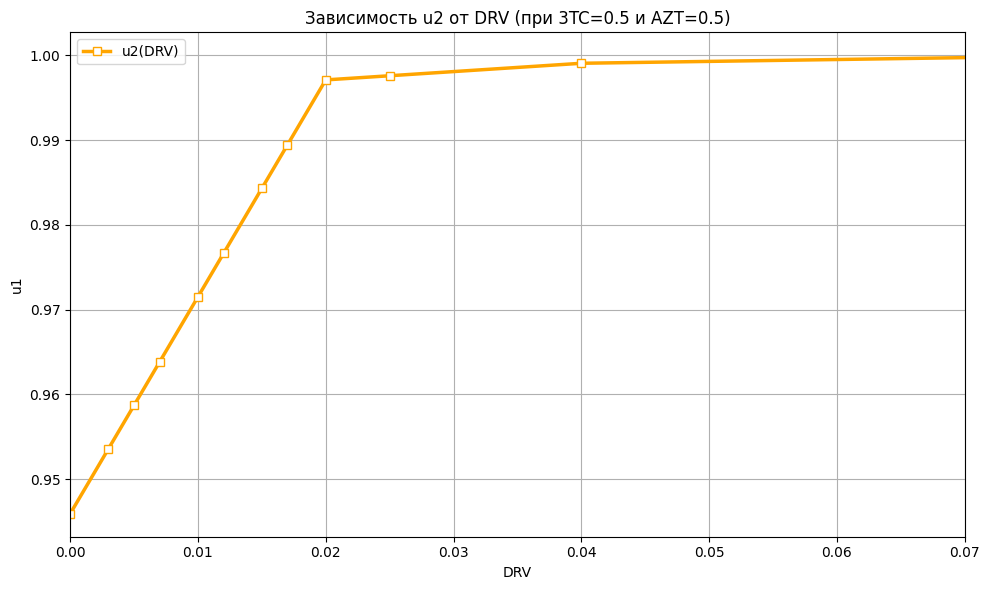

In [33]:
plt.figure(figsize=(10, 6))

plt.plot(n_PI_values, u2_c1_3d, label='u2(DRV)', color='orange', linewidth=2.5, marker='s', markersize=6, markerfacecolor='white', )
plt.xlabel("DRV")
plt.ylabel("u1")
plt.title("Зависимость u2 от DRV (при 3TC=0.5 и AZT=0.5)")
plt.xlim(0, 0.07)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [34]:
# plt.figure(figsize=(10, 10))
# plt.subplot(2, 1, 1)
# plt.imshow(averaged_matrix[:, 0, :], cmap='viridis', interpolation='nearest')
# plt.colorbar(label='Эффективность')  

# plt.title('Тепловая карта u1', pad=20)
# plt.xlabel('Концентрация DRV')
# plt.ylabel('Концентрация AZT')

# n_ticks = data.shape[0] 
# x_ticks = np.linspace(0, 0.2, n_ticks)
# y_ticks = np.linspace(0, 1, n_ticks)

# # Подписи для осей X и Y
# plt.xticks(np.linspace(0, data.shape[1] - 1, n_ticks), 
#            labels=[f"{x:.2f}" for x in x_ticks])
# plt.yticks(np.linspace(0, data.shape[0] - 1, n_ticks), 
#            labels=[f"{y:.2f}" for y in y_ticks])


# plt.subplot(2, 1, 2)
# plt.imshow(averaged_matrix[0, :, :], cmap='viridis', interpolation='nearest')
# plt.colorbar(label='Эффективность')  

# plt.title('Тепловая карта u1', pad=20)
# plt.xlabel('Концентрация DRV')
# plt.ylabel('Концентрация 3TC')

# n_ticks = data.shape[0] 
# x_ticks = np.linspace(0, 0.2, n_ticks)
# y_ticks = np.linspace(0, 1, n_ticks)

# # Подписи для осей X и Y
# plt.xticks(np.linspace(0, data.shape[1] - 1, n_ticks), 
#            labels=[f"{x:.2f}" for x in x_ticks])
# plt.yticks(np.linspace(0, data.shape[0] - 1, n_ticks), 
#            labels=[f"{y:.2f}" for y in y_ticks])

# plt.tight_layout()
# plt.show()

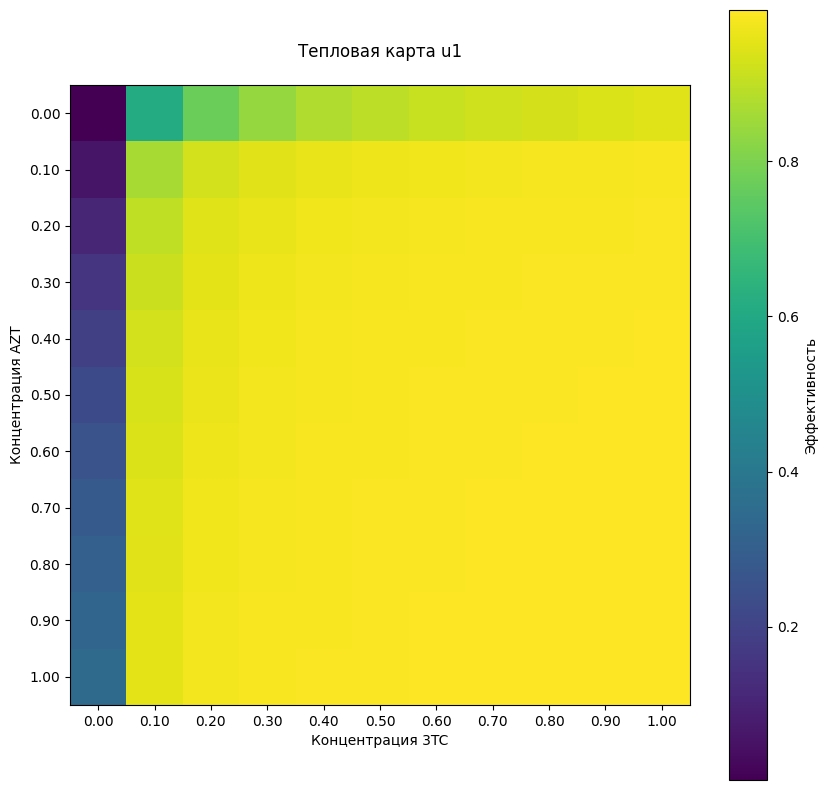

In [35]:
plt.figure(figsize=(10, 10))
plt.imshow(averaged_matrix[:, :, 0], cmap='viridis', interpolation='nearest')
plt.colorbar(label='Эффективность')  

plt.title('Тепловая карта u1', pad=20)
plt.xlabel('Концентрация 3TC')
plt.ylabel('Концентрация AZT')

n_ticks = data.shape[0] 
x_ticks = np.linspace(0, 1, n_ticks)
y_ticks = np.linspace(0, 1, n_ticks)

# Подписи для осей X и Y
plt.xticks(np.linspace(0, data.shape[1] - 1, n_ticks), 
           labels=[f"{x:.2f}" for x in x_ticks])
plt.yticks(np.linspace(0, data.shape[0] - 1, n_ticks), 
           labels=[f"{y:.2f}" for y in y_ticks])
plt.show()

In [36]:
c3_fixed = 0.2
с1_fixed = 0.2
points_c2_3d = np.column_stack([
    np.full_like(n_NRTI1_values, c3_fixed),  # C3 = 0 для всех точек
    n_NRTI1_values,                          # C2 меняется
    np.full_like(n_NRTI2_values, c1_fixed)
])
u1_c2_3d = interpolator_3d(points_c2_3d)

# Зависимость u1 от C3 (при C2=0, C1=0.5)
c2_fixed = 0.2
points_c3_3d = np.column_stack([
    n_NRTI2_values,                          # C3 меняется
    np.full_like(n_NRTI2_values, c2_fixed),  # C2 = 0 для всех точек
    np.full_like(n_NRTI2_values, c1_fixed)
])

u1_c3_3d = interpolator_3d(points_c3_3d)

NameError: name 'c1_fixed' is not defined

In [ ]:
u1_c2_3d

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

NameError: name 'u1_c2_3d' is not defined

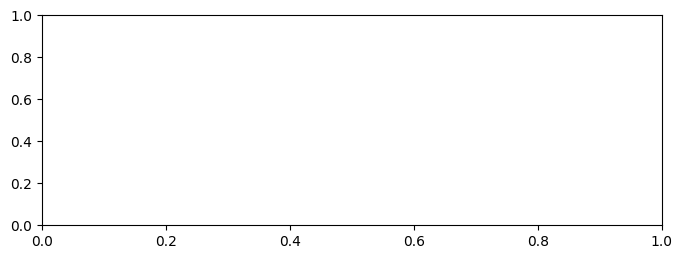

In [37]:
plt.figure(figsize=(8, 6))

plt.subplot(2, 1, 1)
plt.plot(n_NRTI1_values, u1_c2_3d, label='u1(3TC)', color='royalblue', linewidth=2.5, marker='o', markersize=6, markerfacecolor='white')
plt.xlabel("3TC")
plt.ylabel("u1")
plt.title("Зависимость u1 от 3TC (при AZT=0)")
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(n_NRTI2_values, u1_c3_3d, label='u1(AZT)', color='crimson', linewidth=2.5, marker='s', markersize=6, markerfacecolor='white')
plt.xlabel("AZT")
plt.ylabel("u1")
plt.title("Зависимость u1 от AZT (при 3TC=0)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### __calc cells dynamics__

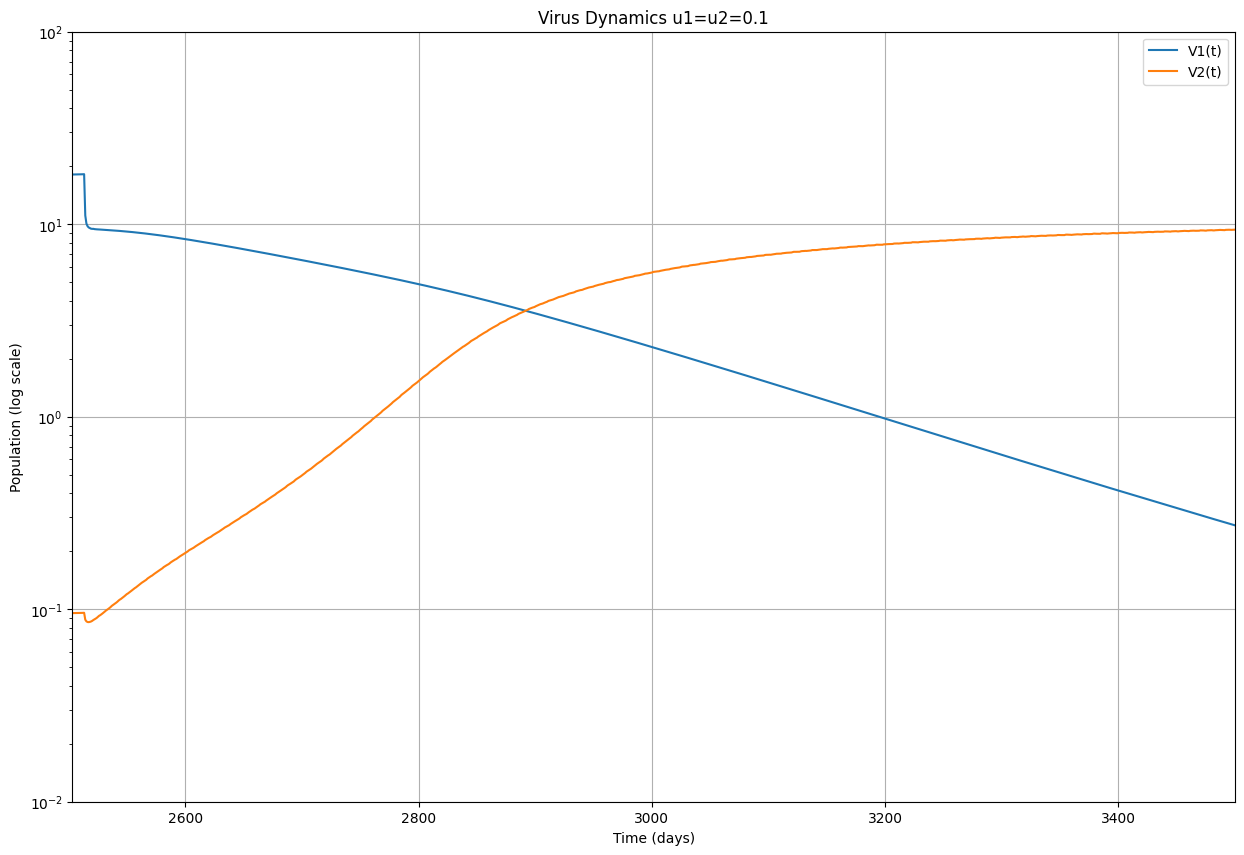

In [38]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Parameters from the table
s1 = 10
s2 = 0.15
s3 = 5
p1 = 0.16
p2 = 0.15
C1 = 55.6
C2 = 188
k1 = 3.87e-3
k2 = 1e-6
k3 = 4.5e-4
k4 = 5.22e-4
k5 = 3e-6
k6 = 3.3e-4
k7 = 6e-9
k8 = 5.37e-1
k9 = 2.85e-1
k10 = 7.79e-6
k11 = 1e-6
k12 = 4e-5
delta1 = 0.02
delta2 = 0.28
delta3 = 0.05
delta4 = 5e-3
delta5 = 5e-3
delta6 = 0.015
delta7 = 2.39
alpha1 = 3e-4
psi = 0.97
phi = 0.9
r = 0.03
T_max = 1500
mu = 0.001
f1 = 0.34
f2 = 0.34

def system(t, y, u1, u2):
    T, T1, T2, TL1, TL2, M, M1, M2, CTL, V1, V2 = y

    # Equation (1)
    dTdt = s1 + (p1 * (V1 + V2) * T) / (V1 + V2 + C1) + r * T * (1 - (T + T1 + T2 + TL1 + TL2) / T_max) - delta1 * T - (1 - u1) * (k1 * V1 + k2 * M1) * T - phi * (k1 * V2 + k2 * M2) * T

    # Equation (2)
    dT1dt = ((1 - u1) * psi * (k1 * V1 + k2 * M1) * T +
           alpha1 * TL1 -
           delta2 * T1 -
           k3 * T1 * CTL)

    # Equation (3)
    dT2dt = (psi * phi * (k1 * V2 + k2 * M2) * T +
             alpha1 * TL2 -
             delta2 * T2 -
             k3 * T2 * CTL)

    # Equation (4)
    dTL1dt = ((1 - u1) * (1 - psi) * (k1 * V1 + k2 * M1) * T -
              alpha1 * TL1 -
              delta3 * TL1)

    # Equation (5)
    dTL2dt = ((1 - psi) * phi * (k1 * V2 + k2 * M2) * T -
              alpha1 * TL2 -
              delta3 * TL2)

    # Equation (6)
    dMdt = (s2 + (p2 * (V1 + V2) * M) / (V1 + V2 + C2) -
            (1 - f1 * u1) * k4 * V1 * M -
            phi * k4 * V2 * M -
            delta4 * M)

    # Equation (7)
    dM1dt = ((1 - f1 * u1) * k4 * V1 * M -
             delta5 * M1 -
             k5 * M1 * CTL)

    # Equation (8)
    dM2dt = (phi * k4 * V2 * M -
             delta5 * M2 -
             k5 * M2 * CTL)

    # Equation (9)
    dCTLdt = (s3 +
              k6 * (T1 + T2) * CTL +
              k7 * (M1 + M2) * CTL -
              delta6 * CTL)

    # Equation (10)
    dV1dt = ((1 - u2) * (1 - mu) * k8 * T1 +
             (1 - f2 * u2) * (1 - mu) * k9 * M1 +
             mu * phi * k8 * T2 +
             mu * phi * k9 * M2 -
             (k10 * T + k11 * M) * V1 -
             k12 * V1 * M -
             delta7 * V1)

    # Equation (11)
    dV2dt = ((1 - mu) * phi * k8 * T2 +
             (1 - mu) * phi * k9 * M2 +
             (1 - u2) * mu * k8 * T1 +
             (1 - f2 * u2) * mu * k9 * M1 -
             (k10 * T + k11 * M) * V2 -
             k12 * V2 * M -
             delta7 * V2)

    return [dTdt, dT1dt, dT2dt, dTL1dt, dTL2dt, dMdt, dM1dt, dM2dt, dCTLdt, dV1dt, dV2dt]

# Initial conditions
y0 = [1000, 0, 0, 0, 0, 30, 0, 0, 333, 0.001, 0]  # T, T1, T2, TL1, TL2, M, M1, M2, CTL, V1, V2

# Phase 1: Run until T-cells reach 200 with u1=u2=0
def event(t, y):
    return y[0] - 350  # Trigger when T-cells reach 200
event.terminal = True

sol_phase1 = solve_ivp(lambda t, y: system(t, y, 0, 0), [0, 3500], y0, events=event, dense_output=True)

# Get the time when T-cells reached 200
switch_time = sol_phase1.t_events[0][0]

# Get the state at switching time
y_switch = sol_phase1.sol(switch_time)

# Phase 2: Continue with u1=u2=0.7
sol_phase2 = solve_ivp(lambda t, y: system(t, y, 0.1, 0.7),
                      [switch_time, 3500],
                      y_switch,
                      t_eval=np.linspace(switch_time, 3500, 1000))

# Combine results
combined_t = np.concatenate([sol_phase1.t, sol_phase2.t])
combined_y = np.hstack([sol_phase1.y, sol_phase2.y])

# Plot results
plt.figure(figsize=(15, 10))


plt.subplot(1, 1, 1)
plt.semilogy(combined_t, combined_y[9], label='V1(t)')
plt.semilogy(combined_t, combined_y[10], label='V2(t)')
# plt.axvline(x=switch_time, color='r', linestyle='--', label='Treatment start')
plt.xlabel('Time (days)')
plt.ylabel('Population (log scale)')
plt.title('Virus Dynamics u1=u2=0.1')
plt.legend()
plt.grid(True)
plt.xlim(switch_time-10, 3500)
plt.ylim(0.01, 100)
plt.show()


t_pi = combined_y[0]
v1_pi = combined_y[-2]
v2_pi = combined_y[-1]

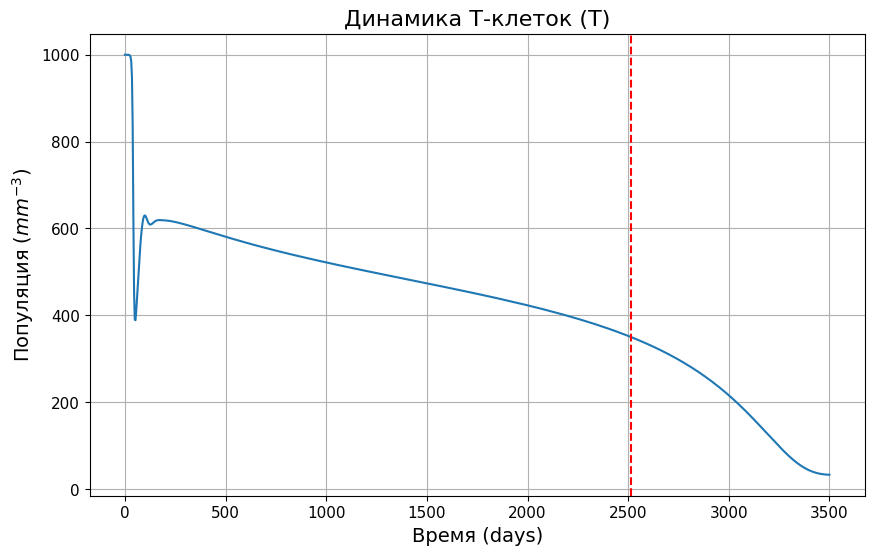

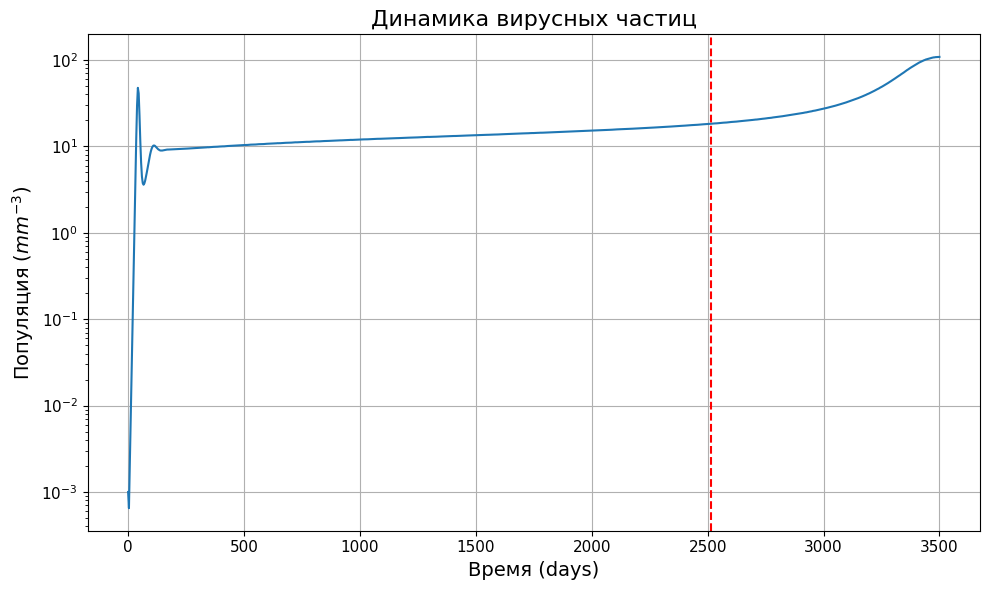

In [2]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Parameters from the table
s1 = 10
s2 = 0.15
s3 = 5
p1 = 0.16
p2 = 0.15
C1 = 55.6
C2 = 188
k1 = 3.87e-3
k2 = 1e-6
k3 = 4.5e-4
k4 = 5.22e-4
k5 = 3e-6
k6 = 3.3e-4
k7 = 6e-9
k8 = 5.37e-1
k9 = 2.85e-1
k10 = 7.79e-6
k11 = 1e-6
k12 = 4e-5
delta1 = 0.02
delta2 = 0.28
delta3 = 0.05
delta4 = 5e-3
delta5 = 5e-3
delta6 = 0.015
delta7 = 2.39
alpha1 = 3e-4
psi = 0.97
phi = 0.9
r = 0.03
T_max = 1500
mu = 0.001
f1 = 0.34
f2 = 0.34  # Assuming f2 is same as f1 since not specified

# Set u1 and u2 to 0 as requested
u1 = 0
u2 = 0


def system(t, y):
    T, T1, T2, TL1, TL2, M, M1, M2, CTL, V1, V2 = y

    # Equation (1)
    dTdt = s1 + (p1 * (V1 + V2) * T) / (V1 + V2 + C1) + r * T * (1 - (T + T1 + T2 + TL1 + TL2) / T_max) - delta1 * T - (1 - u1) * (k1 * V1 + k2 * M1) * T - phi * (k1 * V2 + k2 * M2) * T

# Equation (2)
    dT1dt = ((1 - u1) * psi * (k1 * V1 + k2 * M1) * T +
           alpha1 * TL1 -
           delta2 * T1 -
           k3 * T1 * CTL)

    # Equation (3)
    dT2dt = (psi * phi * (k1 * V2 + k2 * M2) * T +
             alpha1 * TL2 -
             delta2 * T2 -
             k3 * T2 * CTL)

    # Equation (4)
    dTL1dt = ((1 - u1) * (1 - psi) * (k1 * V1 + k2 * M1) * T -
              alpha1 * TL1 -
              delta3 * TL1)

    # Equation (5)
    dTL2dt = ((1 - psi) * phi * (k1 * V2 + k2 * M2) * T -
              alpha1 * TL2 -
              delta3 * TL2)

    # Equation (6)
    dMdt = (s2 + (p2 * (V1 + V2) * M) / (V1 + V2 + C2) -
            (1 - f1 * u1) * k4 * V1 * M -
            phi * k4 * V2 * M -
            delta4 * M)

    # Equation (7)
    dM1dt = ((1 - f1 * u1) * k4 * V1 * M -
             delta5 * M1 -
             k5 * M1 * CTL)

    # Equation (8)
    dM2dt = (phi * k4 * V2 * M -
             delta5 * M2 -
             k5 * M2 * CTL)

    # Equation (9)
    dCTLdt = (s3 +
              k6 * (T1 + T2) * CTL +
              k7 * (M1 + M2) * CTL -
              delta6 * CTL)

    # Equation (10)
    dV1dt = ((1 - u2) * (1 - mu) * k8 * T1 +
             (1 - f2 * u2) * (1 - mu) * k9 * M1 +
             mu * phi * k8 * T2 +
             mu * phi * k9 * M2 -
             (k10 * T + k11 * M) * V1 -
             k12 * V1 * M -
             delta7 * V1)

    # Equation (11)
    dV2dt = ((1 - mu) * phi * k8 * T2 +
             (1 - mu) * phi * k9 * M2 +
             (1 - u2) * mu * k8 * T1 +
             (1 - f2 * u2) * mu * k9 * M1 -
             (k10 * T + k11 * M) * V2 -
             k12 * V2 * M -
             delta7 * V2)

    return [dTdt, dT1dt, dT2dt, dTL1dt, dTL2dt, dMdt, dM1dt, dM2dt, dCTLdt, dV1dt, dV2dt]


# Initial conditions (assuming all start at 1 if not specified)
y0 = [1000, 0, 0, 0, 0, 30, 0, 0, 333, 0.001, 0]  #    T, T1, T2, TL1, TL2, M, M1, M2, CTL, V1, V2

# Time span (0 to 100 days)
t_span = (0, 3500)
t_eval = np.linspace(t_span[0], t_span[1], 1000)

# Solve the system
sol = solve_ivp(system, t_span, y0, t_eval=t_eval)

# Plot results
plt.figure(figsize=(10, 6))

# Tumor cells
plt.plot(sol.t, sol.y[0], label='T(t)')
plt.axvline(x=switch_time, color='r', linestyle='--', label='Treatment starts')
plt.xlabel('Время (days)', fontsize=14)
plt.ylabel('Популяция ($mm^{-3}$)', fontsize=14) 
plt.title('Динамика Т-клеток (T)', fontsize=16)
plt.grid(True)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.show()


plt.figure(figsize=(10, 6))
plt.semilogy(sol.t, sol.y[9] + sol.y[10], label='V1(t) + V2(t)')
# plt.semilogy(sol.t, sol.y[10], label='V2(t)')
plt.axvline(x=switch_time, color='r', linestyle='--', label='Treatment starts')
plt.xlabel('Время (days)', fontsize=14)
plt.ylabel('Популяция ($mm^{-3}$)', fontsize=14)
plt.title('Динамика вирусных частиц', fontsize=16)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.grid(True)

plt.tight_layout()
plt.show()

In [3]:
def calculate_concentration_month_gap(t, drug_params, num_doses):
    D = drug_params["D"]
    k_a = drug_params["k_a"]
    Cl = drug_params["Cl"]
    V_c = drug_params["V_c"]
    F = drug_params["F"]
    tau = drug_params["tau"]

    k_e = Cl / V_c  # константа скорости элиминации

    C_t = np.zeros_like(t)

    for l in range(num_doses):
        if (l // 180) % 2 == 0:
          t_dose = l * tau  # время введения дозы
          mask = (t >= t_dose)  # рассматриваем время после введения дозы

          term1 = np.exp(-k_e * (t[mask] - t_dose))
          term2 = (F * D / V_c) * (k_a / (k_a - k_e)) * (np.exp(-k_e * (t[mask] - t_dose)) - np.exp(-k_a * (t[mask] - t_dose)))

          if l == 0:
              C_t[mask] = term1 * 0 + term2  # начальная концентрация C_i(t_0) = 0
          else:
              C_t[mask] = C_t[mask] * np.exp(-k_e * (t[mask] - t_dose)) + term2


    return C_t


def calculate_concentration(t, drug_params, num_doses):
    D = drug_params["D"]
    k_a = drug_params["k_a"]
    Cl = drug_params["Cl"]
    V_c = drug_params["V_c"]
    F = drug_params["F"]
    tau = drug_params["tau"]

    k_e = Cl / V_c  # константа скорости элиминации

    C_t = np.zeros_like(t)

    for l in range(num_doses):
        t_dose = l * tau  # время введения дозы
        mask = (t >= t_dose)  # рассматриваем время после введения дозы

        term1 = np.exp(-k_e * (t[mask] - t_dose))
        term2 = (F * D / V_c) * (k_a / (k_a - k_e)) * (np.exp(-k_e * (t[mask] - t_dose)) - np.exp(-k_a * (t[mask] - t_dose)))

        if l == 0:
            C_t[mask] = term1 * 0 + term2  # начальная концентрация C_i(t_0) = 0
        else:
            C_t[mask] = C_t[mask] * np.exp(-k_e * (t[mask] - t_dose)) + term2

    return C_t


In [4]:
# Параметры для каждого лекарства (из таблицы V)
drugs = {
    "RDV": {
        "D": 600,       # мг
        "k_a": 2.4,     # д^-1
        "Cl": 1.48e4,   # л/день
        "V_c": 28.7,    # л
        "F": 1.0,       # безразмерный
        "tau": 1/2,     # день (интервал дозирования)
        "IC50": 0.11    # мг/л
    },
    "3TC": {
        "D": 150,
        "k_a": 12,
        "Cl": 5.6e2,
        "V_c": 91,
        "F": 0.86,
        "tau": 1/2,
        "IC50": 0.34
    },
    "ZDV": {
        "D": 300,
        "k_a": 12,
        "Cl": 2.69e3,
        "V_c": 112,
        "F": 0.64,
        "tau": 1/2,
        "IC50": 0.13
    }
}


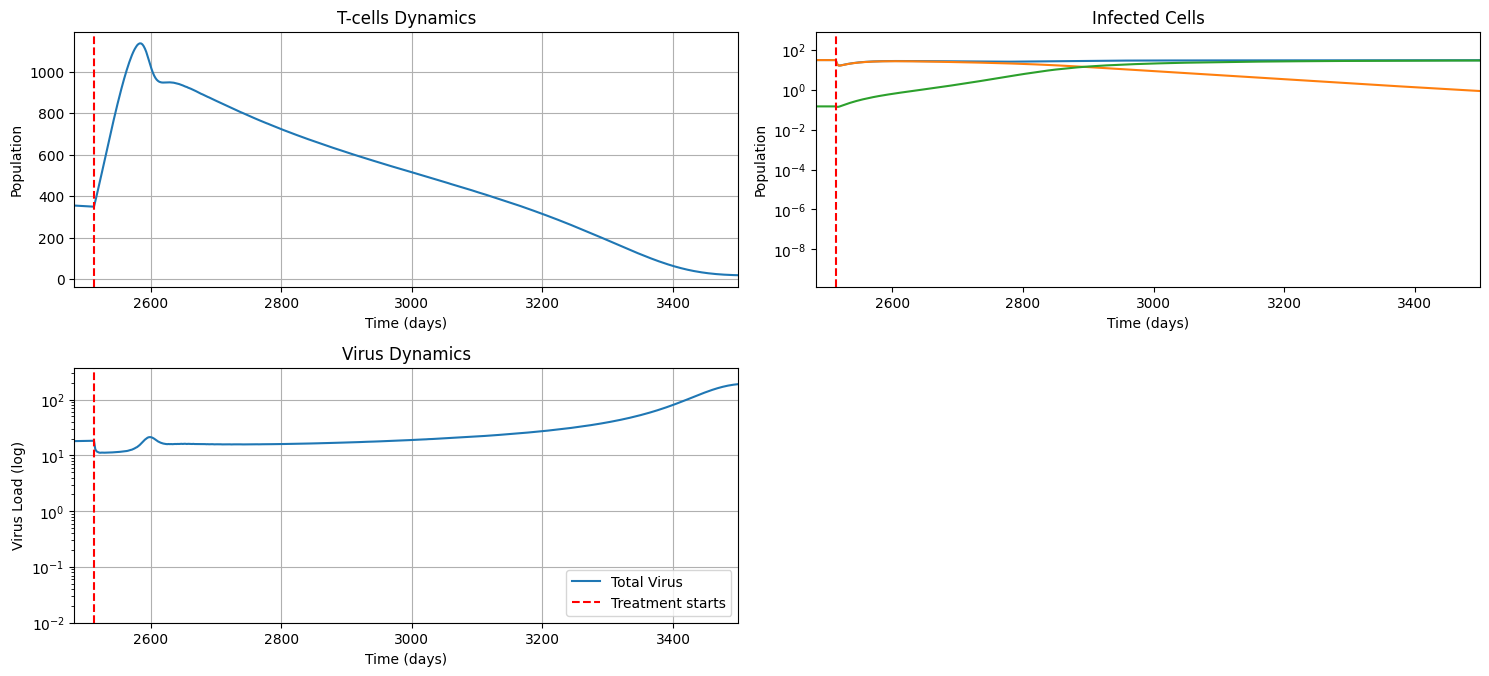

In [11]:
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d

# Time points for drug concentration calculation (3 days with 300 points)
treatment_duration_days = 2000
t = np.linspace(0, treatment_duration_days, 6000)

# Calculate drug concentrations
C_1 = calculate_concentration(t, drugs["RDV"], treatment_duration_days * 2)  # RDV (C1)
C_2 = calculate_concentration(t, drugs["3TC"], treatment_duration_days * 2)  # 3TC (C2)
C_3 = calculate_concentration(t, drugs["ZDV"], treatment_duration_days * 2)  # ZDV (C3)

# C_1_func = interp1d(t, C_1, bounds_error=False, fill_value=(0, 1)) # RDV (C1)
# C_2_func = interp1d(t, C_2, bounds_error=False, fill_value=(0, 1))  # 3TC (C2)
# C_3_func = interp1d(t, C_3, bounds_error=False, fill_value=(0, 1))  # ZDV (C3)


# IC50 values
IC50_1 = drugs["RDV"]["IC50"]
IC50_2 = drugs["3TC"]["IC50"]
IC50_3 = drugs["ZDV"]["IC50"]

# Calculate u1(t) and u2(t)
omega = 1
u1 = ((C_2/IC50_2) + (C_3/IC50_3)) / (1 + (C_2/IC50_2) + (C_3/IC50_3))
u2 = C_1 / (C_1 + omega * IC50_1)


u1_func = interp1d(t, u1, bounds_error=False, fill_value=(u1[0], u1[-1]))
u2_func = interp1d(t, u2, bounds_error=False, fill_value=(u2[0], u2[-1]))


def system(t, y, u1=None, u2=None, switch_time=None):

    T, T1, T2, TL1, TL2, M, M1, M2, CTL, V1, V2 = y
    global u1_func, u2_func

    if u1 is None or u2 is None:
      # print(t-switch_time)
      # if ((t-switch_time)//30) % 2 == 0:
      # u1 = u1_func((C_2_func(t-switch_time), C_1_func(t-switch_time)))
      # u2 = u2_func((C_3_func(t-switch_time), C_2_func(t-switch_time), C_1_func(t-switch_time)))
      # else:

      u1 = u1_func(t-switch_time)
      u2 = u2_func(t-switch_time)
      # print((C_3_func(t-switch_time), C_2_func(t-switch_time), C_1_func(t-switch_time)), u1, u2)



    dTdt = s1 + (p1 * (V1 + V2) * T) / (V1 + V2 + C1) + r * T * (1 - (T + T1 + T2 + TL1 + TL2) / T_max) - delta1 * T - (1 - u1) * (k1 * V1 + k2 * M1) * T - phi * (k1 * V2 + k2 * M2) * T

    # Equation (2)
    dT1dt = ((1 - u1) * psi * (k1 * V1 + k2 * M1) * T +
           alpha1 * TL1 -
           delta2 * T1 -
           k3 * T1 * CTL)

    # Equation (3)
    dT2dt = (psi * phi * (k1 * V2 + k2 * M2) * T +
             alpha1 * TL2 -
             delta2 * T2 -
             k3 * T2 * CTL)

    # Equation (4)
    dTL1dt = ((1 - u1) * (1 - psi) * (k1 * V1 + k2 * M1) * T -
              alpha1 * TL1 -
              delta3 * TL1)

    # Equation (5)
    dTL2dt = ((1 - psi) * phi * (k1 * V2 + k2 * M2) * T -
              alpha1 * TL2 -
              delta3 * TL2)

    # Equation (6)
    dMdt = (s2 + (p2 * (V1 + V2) * M) / (V1 + V2 + C2) -
            (1 - f1 * u1) * k4 * V1 * M -
            phi * k4 * V2 * M -
            delta4 * M)

    # Equation (7)
    dM1dt = ((1 - f1 * u1) * k4 * V1 * M -
             delta5 * M1 -
             k5 * M1 * CTL)

    # Equation (8)
    dM2dt = (phi * k4 * V2 * M -
             delta5 * M2 -
             k5 * M2 * CTL)

    # Equation (9)
    dCTLdt = (s3 +
              k6 * (T1 + T2) * CTL +
              k7 * (M1 + M2) * CTL -
              delta6 * CTL)

    # Equation (10)
    dV1dt = ((1 - u2) * (1 - mu) * k8 * T1 +
             (1 - f2 * u2) * (1 - mu) * k9 * M1 +
             mu * phi * k8 * T2 +
             mu * phi * k9 * M2 -
             (k10 * T + k11 * M) * V1 -
             k12 * V1 * M -
             delta7 * V1)

    # Equation (11)
    dV2dt = ((1 - mu) * phi * k8 * T2 +
             (1 - mu) * phi * k9 * M2 +
             (1 - u2) * mu * k8 * T1 +
             (1 - f2 * u2) * mu * k9 * M1 -
             (k10 * T + k11 * M) * V2 -
             k12 * V2 * M -
             delta7 * V2)

    return [dTdt, dT1dt, dT2dt, dTL1dt, dTL2dt, dMdt, dM1dt, dM2dt, dCTLdt, dV1dt, dV2dt]



y0 = [1000, 0, 0, 0, 0, 30, 0, 0, 333, 0.001, 0]  # T, T1, T2, TL1, TL2, M, M1, M2, CTL, V1, V2

# Phase 1: Run until T-cells reach 200 with u1=u2=0
def event(t, y):
    return y[0] - 350  # Trigger when T-cells reach 200
event.terminal = True

sol_phase1 = solve_ivp(lambda t, y: system(t, y, 0, 0), [0, 3500], y0, events=event, dense_output=True)

# Get the time when T-cells reached 200
switch_time = sol_phase1.t_events[0][0]

# Get the state at switching time
y_switch = sol_phase1.sol(switch_time)

# Phase 2: Continue with u1=u2=0.7
sol_phase2 = solve_ivp(lambda t, y: system(t, y, None, None, switch_time),
                      [switch_time, treatment_duration_days + switch_time],
                      y_switch,
                      t_eval=np.linspace(switch_time, treatment_duration_days + switch_time, 1000))

# Combine results
combined_t_new = np.concatenate([sol_phase1.t, sol_phase2.t])
combined_y_new = np.hstack([sol_phase1.y, sol_phase2.y])




plt.figure(figsize=(15, 10))

# # Plot drug concentrations
# plt.subplot(3, 2, 1)
# plt.plot(t + switch_time, C_1, label='RDV (C1)')
# plt.plot(t + switch_time, C_2, label='3TC (C2)')
# plt.plot(t + switch_time, C_3, label='ZDV (C3)')
# plt.xlabel('Time (hours)')
# plt.ylabel('Concentration')
# plt.title('Drug Concentrations')
# plt.legend()
# plt.grid(True)

# # Plot treatment efficacy
# plt.subplot(3, 2, 2)
# plt.plot(t + switch_time, u1, label='u1(t)')
# plt.plot(t + switch_time, u2, label='u2(t)')
# plt.xlabel('Time (hours)')
# plt.ylabel('Efficacy')
# plt.title('Treatment Efficacy')
# plt.legend()
# plt.grid(True)

# Plot T-cells


plt.subplot(3, 2, 3)
plt.plot(combined_t_new, combined_y_new[0], label='T(t)')
plt.axvline(x=switch_time, color='r', linestyle='--', label='Treatment starts')
plt.xlabel('Time (days)')
plt.ylabel('Population')
plt.title('T-cells Dynamics')
plt.xlim(switch_time - 30, 3500)
plt.grid(True)

# Plot Infected cells
plt.subplot(3, 2, 4)
plt.plot(combined_t, combined_y[1] + combined_y[2], label='Infected T-cells')
plt.semilogy(combined_t, combined_y[1], label='V1(t)')
plt.semilogy(combined_t, combined_y[2], label='V2(t)')
plt.axvline(x=switch_time, color='r', linestyle='--', label='Vertical Line at x=5')
plt.xlabel('Time (days)')
plt.ylabel('Population')
plt.title('Infected Cells')
plt.xlim(switch_time - 30, 3500)
# plt.grid(True)

# Plot Viruses (log scale)
plt.subplot(3, 2, 5)
plt.semilogy(combined_t_new, combined_y_new[9] + combined_y_new[10], label='Total Virus')
# plt.semilogy(combined_t_new, combined_y_new[9], label='V1(t)')
# plt.semilogy(combined_t_new, combined_y_new[10], label='V2(t)')
plt.axvline(x=switch_time, color='r', linestyle='--', label='Treatment starts')
plt.xlabel('Time (days)')
plt.ylabel('Virus Load (log)')
plt.title('Virus Dynamics')
plt.xlim(switch_time - 30, 3500)
plt.ylim(1e-2)
plt.grid(True)

# Plot CTL
# plt.subplot(3, 2, 6)
# plt.plot(combined_t, combined_y[8], label='CTL')
# plt.axvline(x=switch_time, color='r', linestyle='--', label='Vertical Line at x=5')
# plt.xlabel('Time (days)')
# plt.ylabel('Population')
# plt.title('CTL Dynamics')
# plt.xlim(switch_time - 30, 3500)
# plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

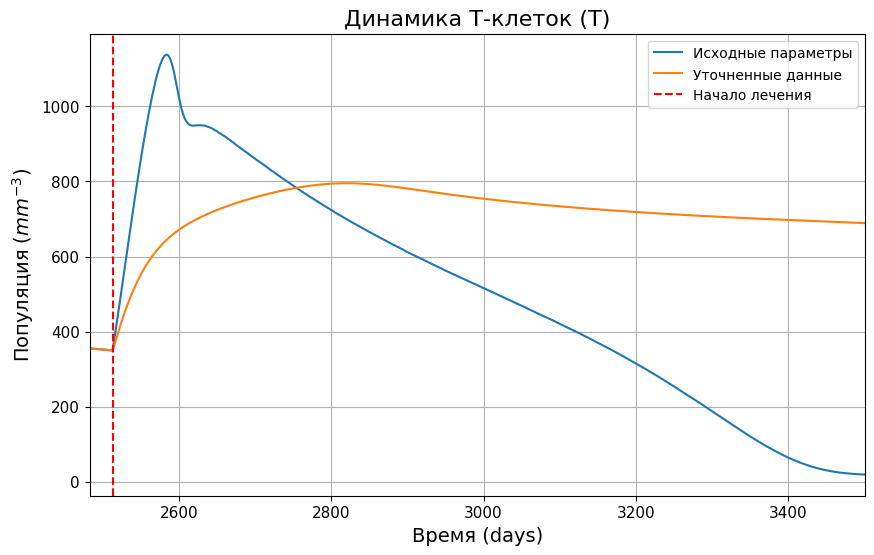

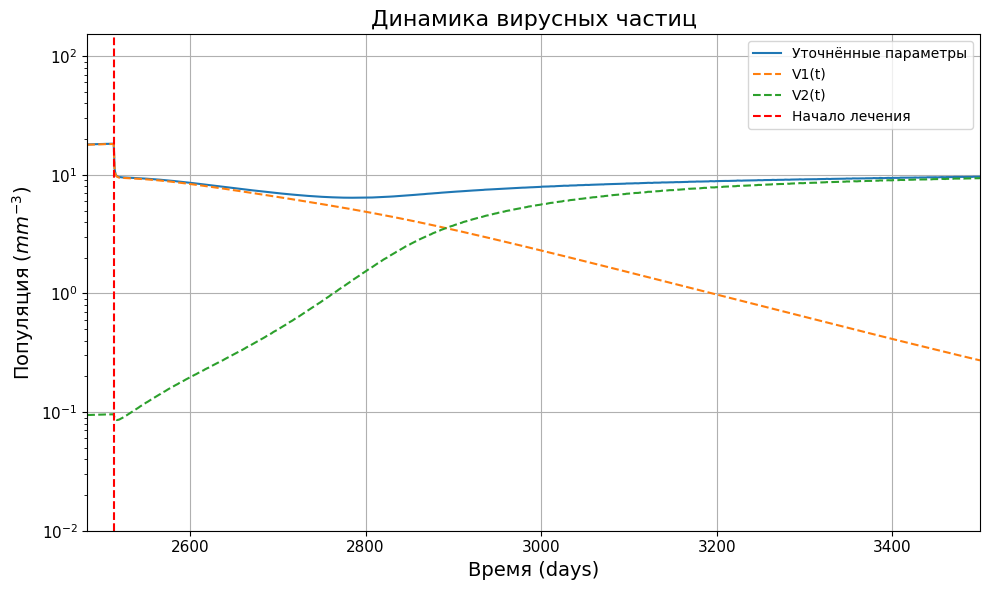

In [17]:
plt.figure(figsize=(10, 6))
# plt.subplot(2, 1, 1)
plt.plot(combined_t_new, combined_y_new[0], label='Исходные параметры')
plt.plot(combined_t, combined_y[0], label='Уточненные данные')
plt.axvline(x=switch_time, color='r', linestyle='--', label='Начало лечения')
plt.xlabel('Время (days)', fontsize=14)
plt.ylabel('Популяция ($mm^{-3}$)', fontsize=14)
plt.title('Динамика Т-клеток (T)', fontsize=16)
plt.xlim(switch_time - 30, 3500)
plt.grid(True)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

# Plot Infected cells
# plt.subplot(3, 2, 4)
# plt.plot(combined_t, combined_y[1] + combined_y[2], label='Infected T-cells')
# plt.axvline(x=switch_time, color='r', linestyle='--', label='Vertical Line at x=5')
# plt.xlabel('Time (days)')
# plt.ylabel('Population')
# plt.title('Infected Cells')
plt.xlim(switch_time - 30, 3500)
# # plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))

# Plot Viruses (log scale)
# plt.subplot(2, 1, 2)
# plt.semilogy(combined_t_new, combined_y_new[9] + combined_y_new[10], label='Исходные параметры')
plt.semilogy(combined_t, combined_y[9] + combined_y[10], label='Уточнённые параметры')
plt.semilogy(combined_t, combined_y[9], label='V1(t)', linestyle='--')
plt.semilogy(combined_t, combined_y[10], label='V2(t)', linestyle='--')
plt.axvline(x=switch_time, color='r', linestyle='--', label='Начало лечения')
plt.xlabel('Время (days)', fontsize=14)
plt.ylabel('Популяция ($mm^{-3}$)', fontsize=14)
plt.title('Динамика вирусных частиц', fontsize=16)
plt.xlim(switch_time - 30, 3500)
plt.ylim(1e-2)
plt.grid(True)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
# Plot CTL
# plt.subplot(3, 2, 6)
# plt.plot(combined_t, combined_y[8], label='CTL')
# plt.axvline(x=switch_time, color='r', linestyle='--', label='Vertical Line at x=5')
# plt.xlabel('Time (days)')
# plt.ylabel('Population')
# plt.title('CTL Dynamics')
plt.xlim(switch_time - 30, 3500)
# plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

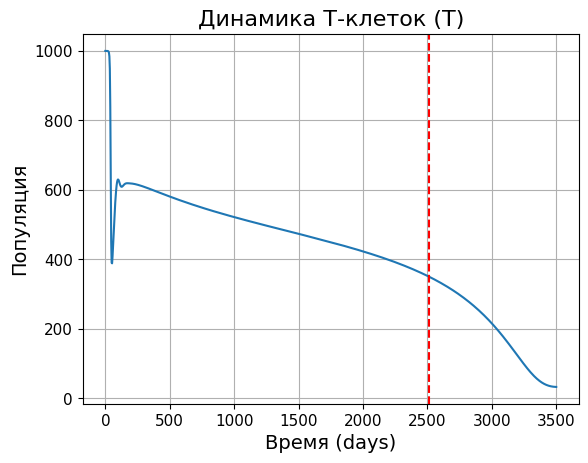

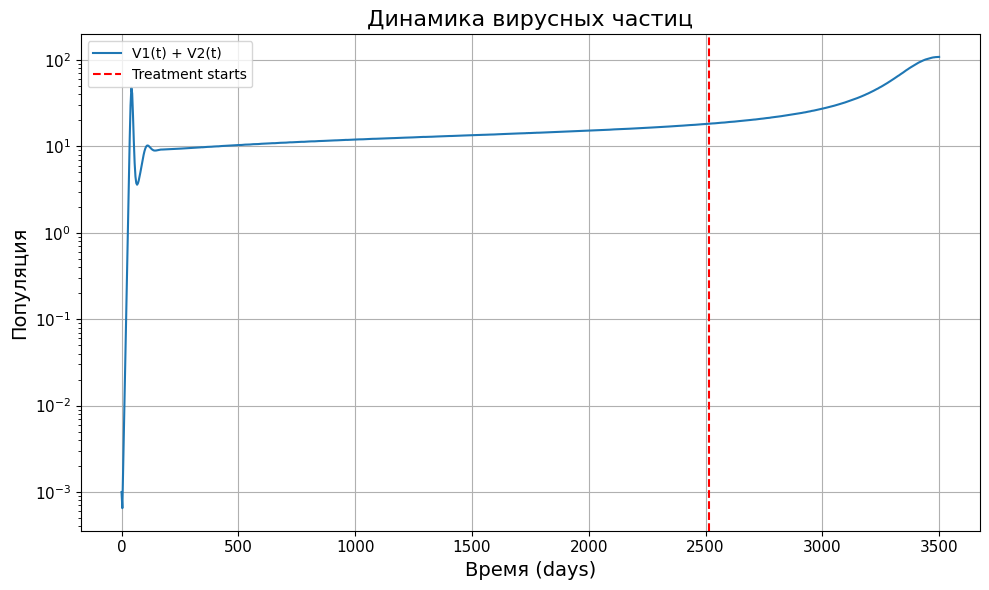

In [7]:

# Tumor cells
plt.plot(sol.t, sol.y[0], label='T(t)')
plt.axvline(x=switch_time, color='r', linestyle='--', label='Treatment starts')
plt.xlabel('Время (days)', fontsize=14)
plt.ylabel('Популяция', fontsize=14)
plt.title('Динамика Т-клеток (T)', fontsize=16)
plt.grid(True)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.show()


plt.figure(figsize=(10, 6))
plt.semilogy(sol.t, sol.y[9] + sol.y[10], label='V1(t) + V2(t)')
# plt.semilogy(sol.t, sol.y[10], label='V2(t)')
plt.axvline(x=switch_time, color='r', linestyle='--', label='Treatment starts')
plt.xlabel('Время (days)', fontsize=14)
plt.ylabel('Популяция', fontsize=14)
plt.title('Динамика вирусных частиц', fontsize=16)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

ValueError: num must be an integer with 1 <= num <= 3, not 4

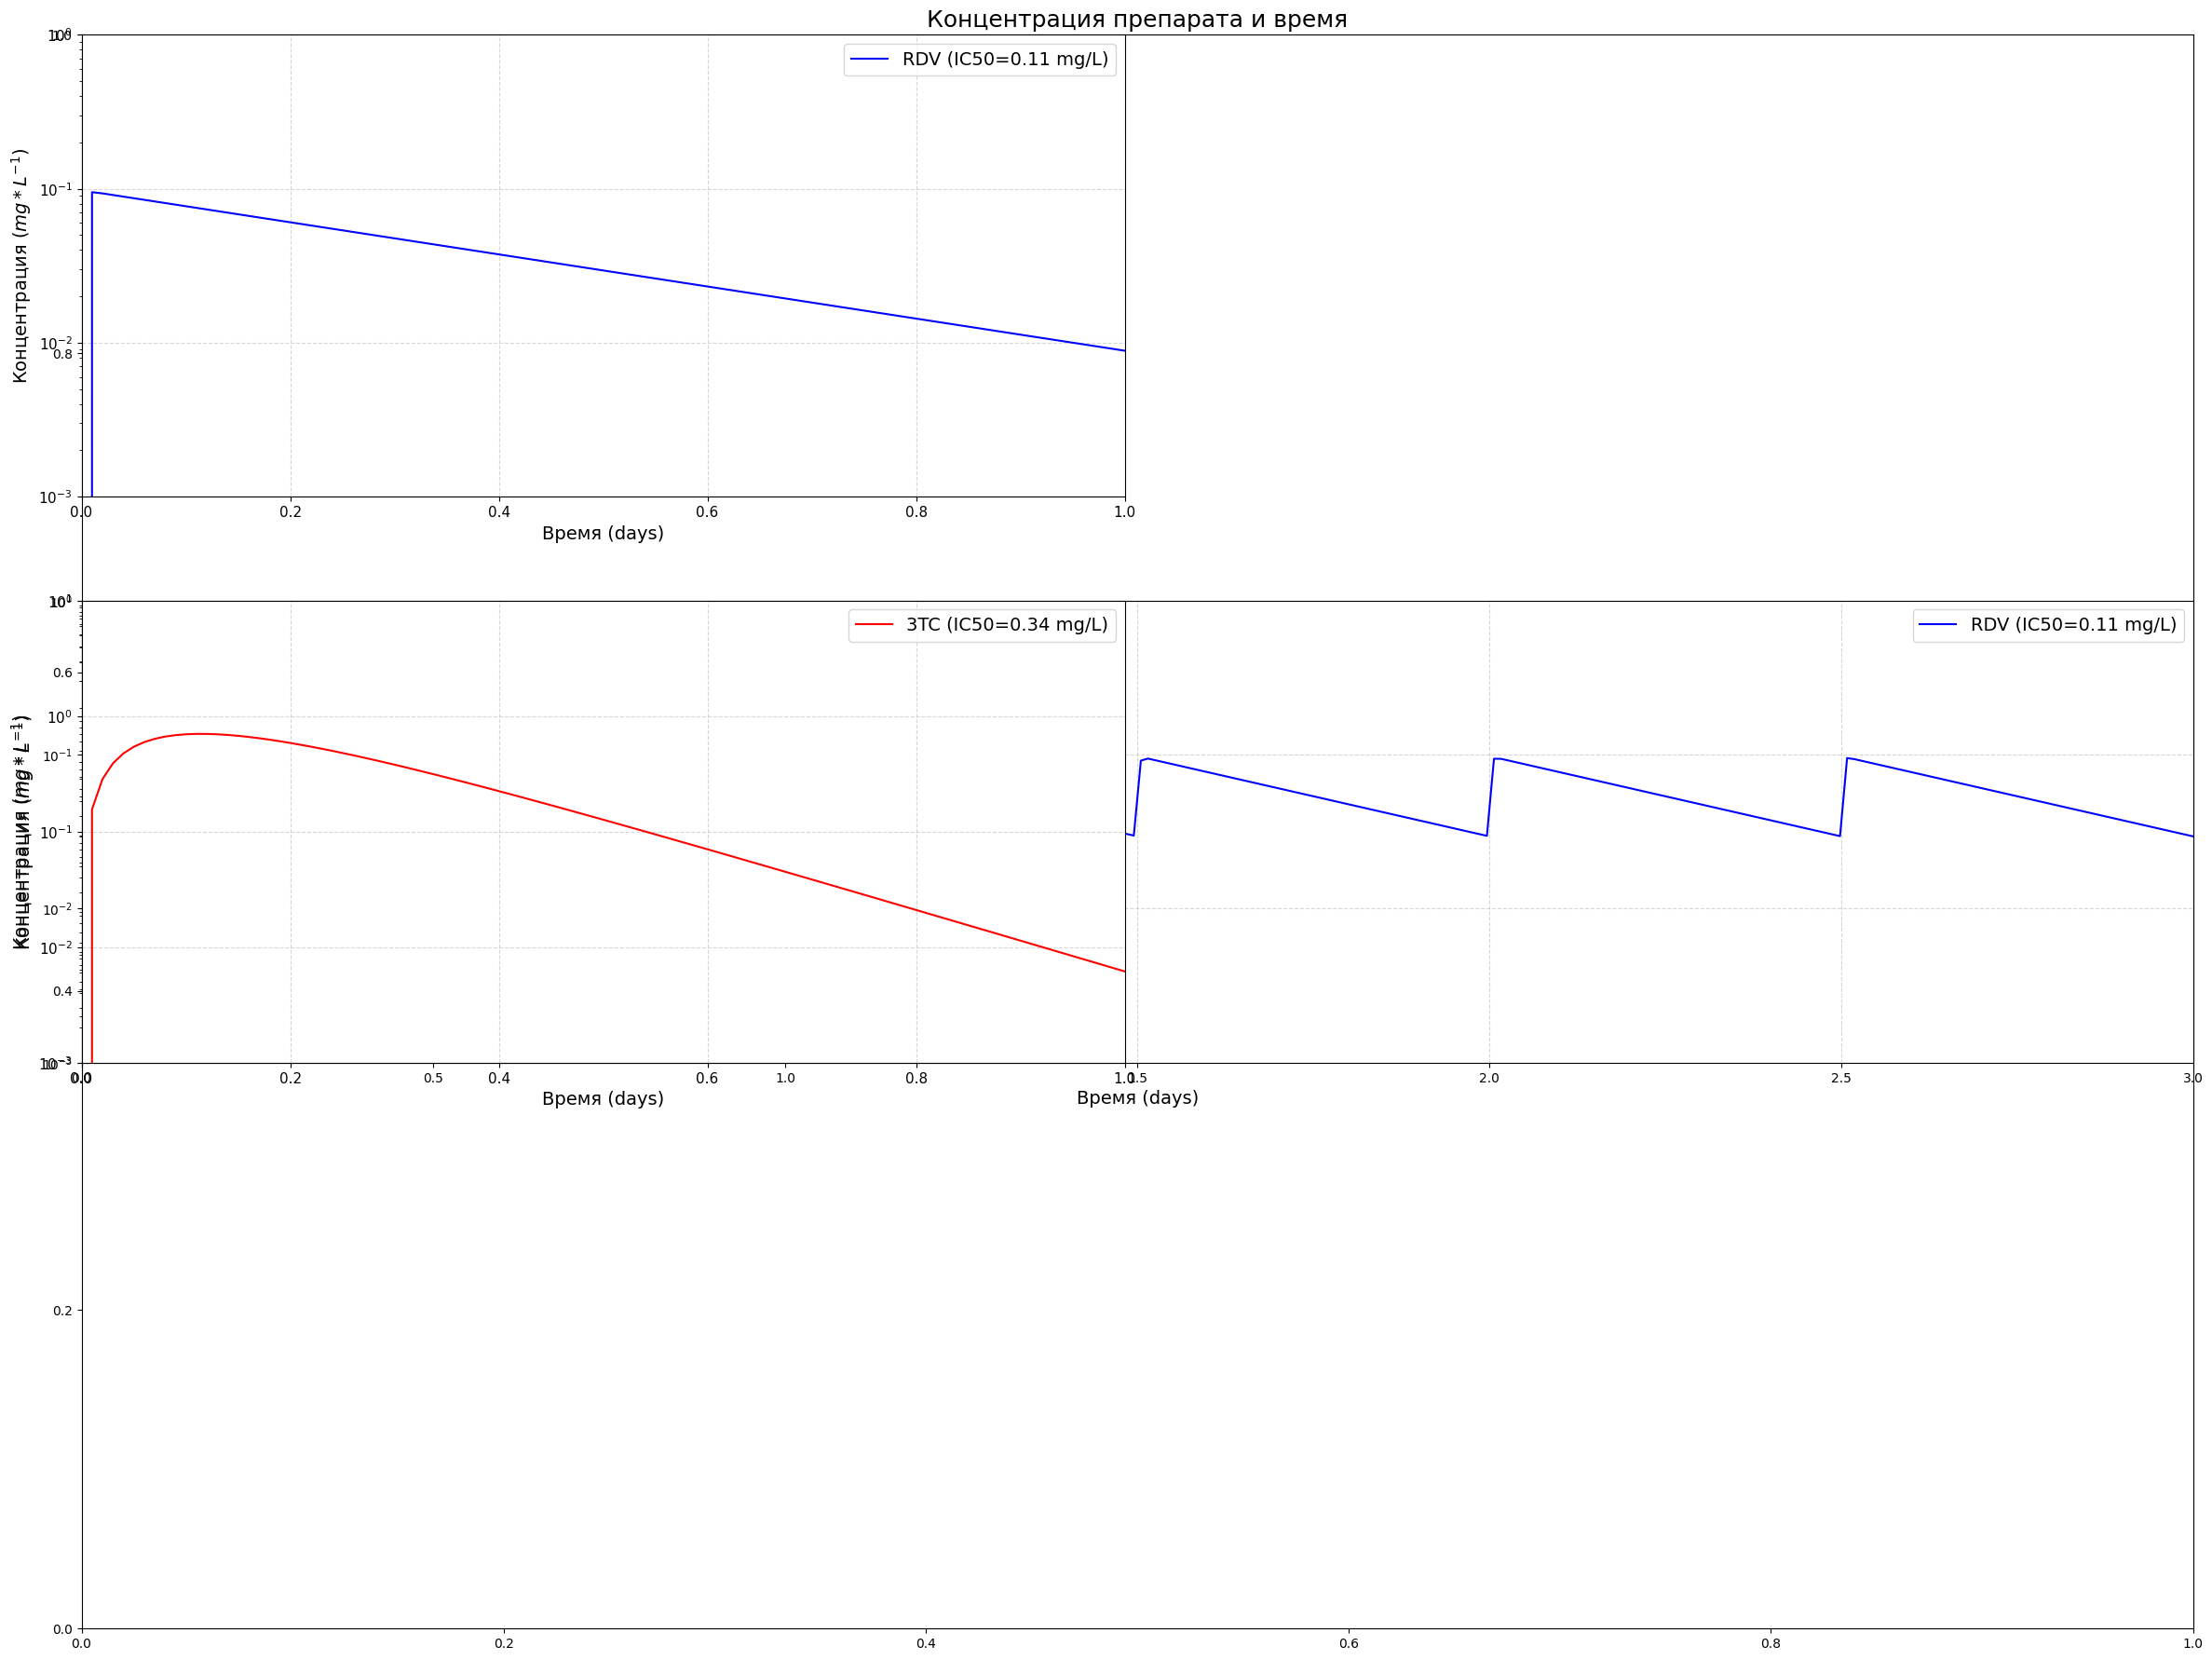

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Параметры для каждого лекарства (из таблицы V)
drugs = {
    "RDV": {
        "D": 600,       # мг
        "k_a": 2.4,     # д^-1
        "Cl": 1.48e4,   # л/день
        "V_c": 28.7,    # л
        "F": 1.0,       # безразмерный
        "tau": 1/2,     # день (интервал дозирования)
        "IC50": 0.11    # мг/л
    },
    "3TC": {
        "D": 150,
        "k_a": 12,
        "Cl": 5.6e2,
        "V_c": 91,
        "F": 0.86,
        "tau": 1/2,
        "IC50": 0.34
    },
    "ZDV": {
        "D": 300,
        "k_a": 12,
        "Cl": 2.69e3,
        "V_c": 112,
        "F": 0.64,
        "tau": 1/2,
        "IC50": 0.13
    }
}

# Функция для расчета концентрации C_i(t)
def calculate_concentration(t, drug_params, num_doses):
    D = drug_params["D"]
    k_a = drug_params["k_a"]
    Cl = drug_params["Cl"]
    V_c = drug_params["V_c"]
    F = drug_params["F"]
    tau = drug_params["tau"]

    k_e = Cl / V_c  # константа скорости элиминации

    C_t = np.zeros_like(t)

    for l in range(num_doses):
        t_dose = l * tau  # время введения дозы
        mask = (t >= t_dose)  # рассматриваем время после введения дозы

        term1 = np.exp(-k_e * (t[mask] - t_dose))
        term2 = (F * D / V_c) * (k_a / (k_a - k_e)) * (np.exp(-k_e * (t[mask] - t_dose)) - np.exp(-k_a * (t[mask] - t_dose)))

        if l == 0:
            C_t[mask] = term1 * 0 + term2  # начальная концентрация C_i(t_0) = 0
        else:
            C_t[mask] = C_t[mask] * np.exp(-k_e * (t[mask] - t_dose)) + term2

    return C_t

# Временной интервал (3 дня с шагом 0.01 дня)
t = np.linspace(0, 3, 300)


def plot_colour(i):
  if i == 1:
    return 'blue'
  elif i == 3:
    return 'red'
  elif i == 5:
    return 'green'


# Построение графиков для каждого лекарства
plt.figure(figsize=(25, 18))
i = 1

plt.title("Концентрация препарата и время", fontsize=18)

for drug_name, params in drugs.items():
    plt.subplot(3, 2, i)
    C_t = calculate_concentration(t, params, 1)
    plt.semilogy(t, C_t, label=f"{drug_name} (IC50={params['IC50']} mg/L)", color=plot_colour(i))

    plt.axhline(y=0, color='gray', linestyle='--', linewidth=0.5)
    plt.xlabel("Время (days)", fontsize=14)
    plt.ylabel("Концентрация $(mg*L^{-1})$", fontsize=14)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.xlim(0, 1)
    if i == 1:
      plt.ylim(0.001, 1)
    elif i == 3:
      plt.ylim(0.001, 10)
    elif i == 5:
      plt.ylim(0.00001, 10)

    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    plt.legend(fontsize=14)



    plt.subplot(3, 1, i+1)
    C_t = calculate_concentration(t, params, 6)
    plt.semilogy(t, C_t, label=f"{drug_name} (IC50={params['IC50']} mg/L)", color=plot_colour(i))

    plt.axhline(y=0, color='gray', linestyle='--', linewidth=0.5)
    plt.xlabel("Время (days)", fontsize=14)
    plt.ylabel("Концентрация $(mg*L^{-1})$", fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.xlim(0, 3)
    if i == 1:
      plt.ylim(0.001, 1)
    elif i == 3:
      plt.ylim(0.01, 10)
    elif i == 5:
      plt.ylim(0.0001, 10)

    i+=2

    plt.legend(fontsize=14)
plt.show()

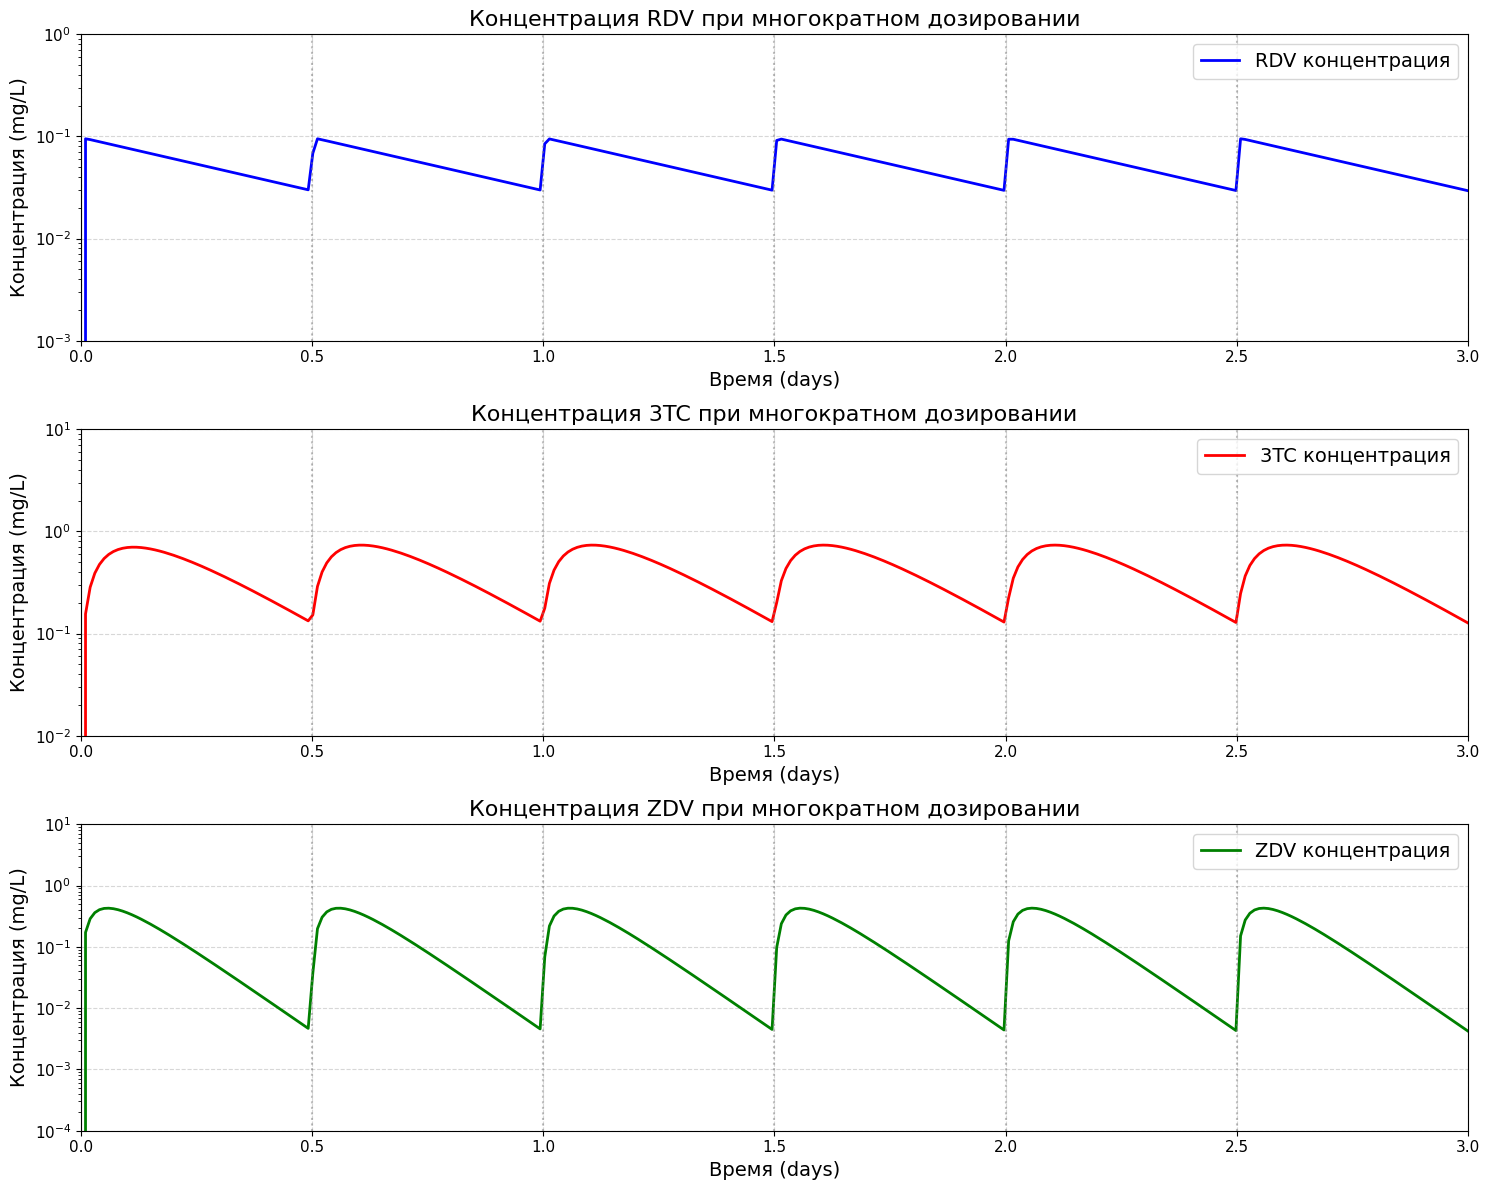

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Параметры для каждого лекарства (из таблицы V)
drugs = {
    "RDV": {
        "D": 600,       # мг
        "k_a": 2.4,     # д^-1
        "Cl": 1.48e4,   # л/день
        "V_c": 28.7,    # л
        "F": 1.0,       # безразмерный
        "tau": 1/2,     # день (интервал дозирования)
        "IC50": 0.11    # мг/л
    },
    "3TC": {
        "D": 150,
        "k_a": 12,
        "Cl": 5.6e2,
        "V_c": 91,
        "F": 0.86,
        "tau": 1/2,
        "IC50": 0.34
    },
    "ZDV": {
        "D": 300,
        "k_a": 12,
        "Cl": 2.69e3,
        "V_c": 112,
        "F": 0.64,
        "tau": 1/2,
        "IC50": 0.13
    }
}

# Функция для расчета концентрации C_i(t)
def calculate_concentration(t, drug_params, num_doses):
    D = drug_params["D"]
    k_a = drug_params["k_a"]
    Cl = drug_params["Cl"]
    V_c = drug_params["V_c"]
    F = drug_params["F"]
    tau = drug_params["tau"]

    k_e = Cl / V_c  # константа скорости элиминации

    C_t = np.zeros_like(t)

    for l in range(num_doses):
        t_dose = l * tau  # время введения дозы
        mask = (t >= t_dose)  # рассматриваем время после введения дозы

        term1 = np.exp(-k_e * (t[mask] - t_dose))
        term2 = (F * D / V_c) * (k_a / (k_a - k_e)) * (np.exp(-k_e * (t[mask] - t_dose)) - np.exp(-k_a * (t[mask] - t_dose)))

        if l == 0:
            C_t[mask] = term1 * 0 + term2  # начальная концентрация C_i(t_0) = 0
        else:
            C_t[mask] = C_t[mask] * np.exp(-k_e * (t[mask] - t_dose)) + term2

    return C_t

# Временной интервал (3 дня с шагом 0.01 дня)
t = np.linspace(0, 3, 300)

# Цвета для каждого препарата
drug_colors = {
    "RDV": "blue",
    "3TC": "red",
    "ZDV": "green"
}

# Создаем фигуру с тремя подграфиками
plt.figure(figsize=(15, 12))

for i, (drug_name, params) in enumerate(drugs.items(), 1):
    plt.subplot(3, 1, i)
    C_t = calculate_concentration(t, params, 6)
    
    # Основной график концентрации
    plt.semilogy(t, C_t, label=f"{drug_name} концентрация", color=drug_colors[drug_name], linewidth=2)
    
    # # Линия IC50
    # plt.axhline(y=params['IC50'], color='black', linestyle='--', 
    #             label=f"IC50 = {params['IC50']} mg/L", linewidth=1.5)
    
    # Настройки графика
    plt.title(f"Концентрация {drug_name} при многократном дозировании", fontsize=16)
    plt.xlabel("Время (days)", fontsize=14)
    plt.ylabel("Концентрация (mg/L)", fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.xlim(0, 3)
    
    # Установка пределов по y в зависимости от препарата
    if drug_name == "RDV":
        plt.ylim(0.001, 1)
    elif drug_name == "3TC":
        plt.ylim(0.01, 10)
    elif drug_name == "ZDV":
        plt.ylim(0.0001, 10)
    
    # Вертикальные линии для каждого времени дозирования
    for dose_time in np.arange(0, 3, params['tau']):
        plt.axvline(x=dose_time, color='gray', linestyle=':', alpha=0.5)
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    plt.legend(fontsize=14, loc='upper right')
    plt.tight_layout()

plt.show()

In [ ]:
import numpy as np
import pandas as pd
from gillespy2 import Model, Species, Parameter, Reaction
from gillespy2 import NumPySSASolver

# 1. Проверка параметров
print("Загружаем параметры...")
params_df = pd.read_csv('parameters.txt', delim_whitespace=True, header=None)
param_names = params_df[0].tolist()
param_values = params_df[1].tolist()

# Выведем важные параметры для проверки
print(f"k_bound = {param_values[0]}")
print(f"k_fuse = {param_values[2]}")
print(f"k_RT = {param_values[3]}")
print(f"k_DNA_i = {param_values[5]}")
print(f"k_int = {param_values[7]}")

# 2. Настройка модели с увеличенным временем
model = Model(name='ViralInfection')

# Виды
species = [
    Species(name="x1", initial_value=4),  # V_free
    Species(name="x2", initial_value=0),  # V_bound
    Species(name="x3", initial_value=0),  # RNA_cor
    Species(name="x4", initial_value=0),  # DNA_cor
    Species(name="x5", initial_value=0),  # DNA_nuc
    Species(name="x6", initial_value=0)   # DNA_int
]
model.add_species(species)

# Параметры (убедимся, что используем правильные индексы)
parameters = [
    Parameter(name="k_bound", expression=str(param_values[0])),    # p1
    Parameter(name="d", expression=str(param_values[49])),          # p50
    Parameter(name="k_fuse", expression=str(param_values[2])),     # p3
    Parameter(name="d_bound", expression=str(param_values[1])),     # p2
    Parameter(name="k_RT", expression=str(param_values[3])),        # p4
    Parameter(name="d_RNA_cor", expression=str(param_values[4])),   # p5
    Parameter(name="k_DNA_i", expression=str(param_values[5])),     # p6
    Parameter(name="d_DNA_cor", expression=str(param_values[6])),   # p7
    Parameter(name="k_int", expression=str(param_values[7])),        # p8
    Parameter(name="d_DNA_nuc", expression=str(param_values[8])),   # p9
    Parameter(name="d_DNA_int", expression=str(param_values[9]))    # p10
]
model.add_parameter(parameters)

# Реакции (упрощенные имена для отладки)
reactions = [
    Reaction("R1", {'x1':1}, {'x2':1}, "k_bound"),
    Reaction("R2", {'x1':1}, {}, "d"),
    Reaction("R3", {'x2':1}, {'x3':1}, "k_fuse"),
    Reaction("R4", {'x2':1}, {}, "d_bound"),
    Reaction("R5", {'x3':1}, {'x4':1}, "k_RT"),
    Reaction("R6", {'x3':1}, {}, "d_RNA_cor"),
    Reaction("R7", {'x4':1}, {'x5':1}, "k_DNA_i"),
    Reaction("R8", {'x4':1}, {}, "d_DNA_cor"),
    Reaction("R9", {'x5':1}, {'x6':1}, "k_int"),
    Reaction("R10", {'x5':1}, {}, "d_DNA_nuc"),
    Reaction("R11", {'x6':1}, {}, "d_DNA_int")
]
model.add_reaction(reactions)

# 3. Увеличим время симуляции и добавим промежуточные точки
t_final = 36.0
n_trajectories = 1001
model.timespan(np.linspace(0, t_final, int(t_final)+1))

# 4. Запуск с подробным выводом
print("\nЗапуск симуляции...")
solver = NumPySSASolver(model)
results = model.run(solver=solver, number_of_trajectories=n_trajectories)

# 5. Анализ результатов
dna_int = np.array([trj['x6'][-1] for trj in results])
p_infected = np.mean(dna_int > 0)
print(f"\nРезультат: {p_infected:.4f}")

Загружаем параметры...
k_bound = 3.1
k_fuse = 0.7
k_RT = 0.43
k_DNA_i = 0.03
k_int = 0.001

Запуск симуляции...


C:\Users\user451\AppData\Local\Temp\ipykernel_13196\3765954300.py:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  params_df = pd.read_csv('parameters.txt', delim_whitespace=True, header=None)



Результат: 0.0340


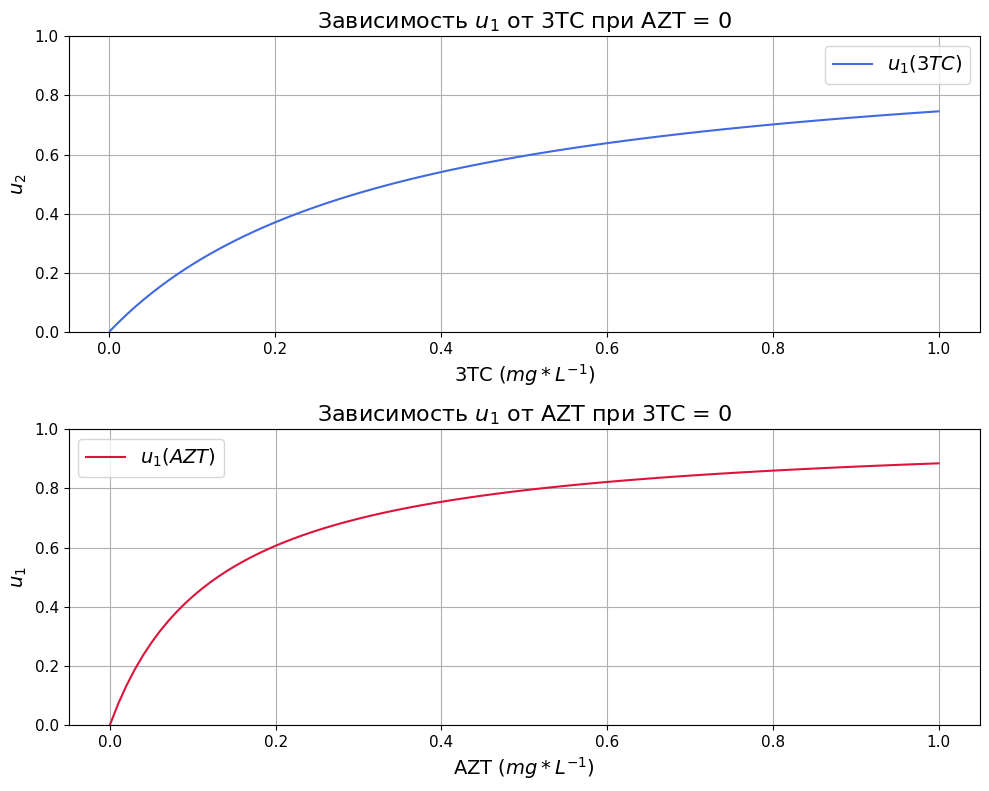

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Предположим, что IC50_2 и IC50_3 заданы (подставьте реальные значения)
IC50_2 = drugs["3TC"]["IC50"]  # Например, 0.1
IC50_3 = drugs["ZDV"]["IC50"]  # Например, 0.05

C1_values = np.linspace(0.001, 1, 100)
u1_values = (C1_values / IC50_2) / (1 + C1_values / IC50_2)
# График u1(C2) при C3 = 0
C2_values = np.linspace(0.001, 1, 100)
u2_values = (C2_values / IC50_2) / (1 + C2_values / IC50_2)

plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
plt.plot(C2_values, u1_values, label='$u_1(3TC)$', color='royalblue')
plt.xlabel('3TC $(mg*L^{-1})$', fontsize=14)
plt.ylabel('$u_2$', fontsize=14)
plt.title('Зависимость $u_1$ от 3TC при AZT = 0', fontsize=16)
plt.grid(True)
plt.ylim(0, 1)
plt.legend(fontsize=14)
plt.tight_layout()

plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

plt.subplot(2, 1, 2)

# График u2(C3) при C2 = 0
C3_values = np.linspace(0.00001, 1, 100)
u2_values = (C3_values / IC50_3) / (1 + C3_values / IC50_3)

plt.plot(C3_values, u2_values, label='$u_1(AZT)$', color='crimson')
plt.xlabel('AZT $(mg*L^{-1})$', fontsize=14)
plt.ylabel('$u_1$', fontsize=14)
plt.title('Зависимость $u_1$ от AZT при 3TC = 0', fontsize=16)
plt.grid(True)
plt.ylim(0, 1)
plt.legend(fontsize=14)
plt.tight_layout()

plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.show()